<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [3504]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, pointbiserialr, spearmanr
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LinearSegmentedColormap
from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3505]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)
df.dropna(subset='work_shift', inplace=True) #  Там где нет смены, там нет и данных (знаем)
df.shape

(4240, 24)

### Стили

In [3506]:
sns.set_theme(style="darkgrid")
color_for_histplot = '#92B755'
line={"color": "#0b412e", "linewidth": 2}
corporate_colors = ["#92B755", "#133215", "#F3E8D3"]
color_for_line = '#133215'

## Исследование данных на качество


### Исследование типов данных 

In [3507]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3508]:
df.head(4)

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
0  2021-01-28 18:00:00                    67.83                    92.99   
1  2021-01-28 19:00:00                    67.83                    91.82   
2  2021-01-28 20:00:00                    67.83                    90.65   
3  2021-01-28 21:00:00                    67.93                    90.24   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
0                          474.18                       76.84   
1                          473.68                       76.15   
2                          473.17                       75.46   
3                          473.59                       75.26   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
0                                 97.52                         49.94   
1                                 97.82                         48.55   
2                                 98.12                         47.15   
3                                 97.79                         49.33   

   stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
0                       361.50                              252.04   
1                       354.75                              244.87   
2                       348.00                              237.70   
3                       356.74                              249.87   

   stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
0                    97.48  ...                         108.65   
1                    97.66  ...                         108.71   
2                    97.85  ...                         108.76   
3                    97.50  ...                         108.63   

   stage_3_output_temp_top  stage_4_input_overheated_steam  \
0                    45.59                          156.67   
1                    45.89                          156.76   
2                    46.19                          156.86   
3                    45.87                          156.41   

   stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
0                  19.08                 5.92               356.05   
1                  19.15                 5.94               357.69   
2                  19.23                 5.97               359.33   
3                  19.36                 5.97               339.99   

   stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
0                        NaN                           21.48   
1                        NaN                           21.48   
2                        NaN                           21.48   
3                       0.16                           21.48   

   stage_4_output_product  work_shift  
0                   47.03         2.0  
1                   45.05         2.0  
2                   43.06         2.0  
3                   46.01         2.0  

[4 rows x 24 columns]

Типы данных

In [3509]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

##### Обработаем datetime для более удобного анализа

### Исследование выбросов

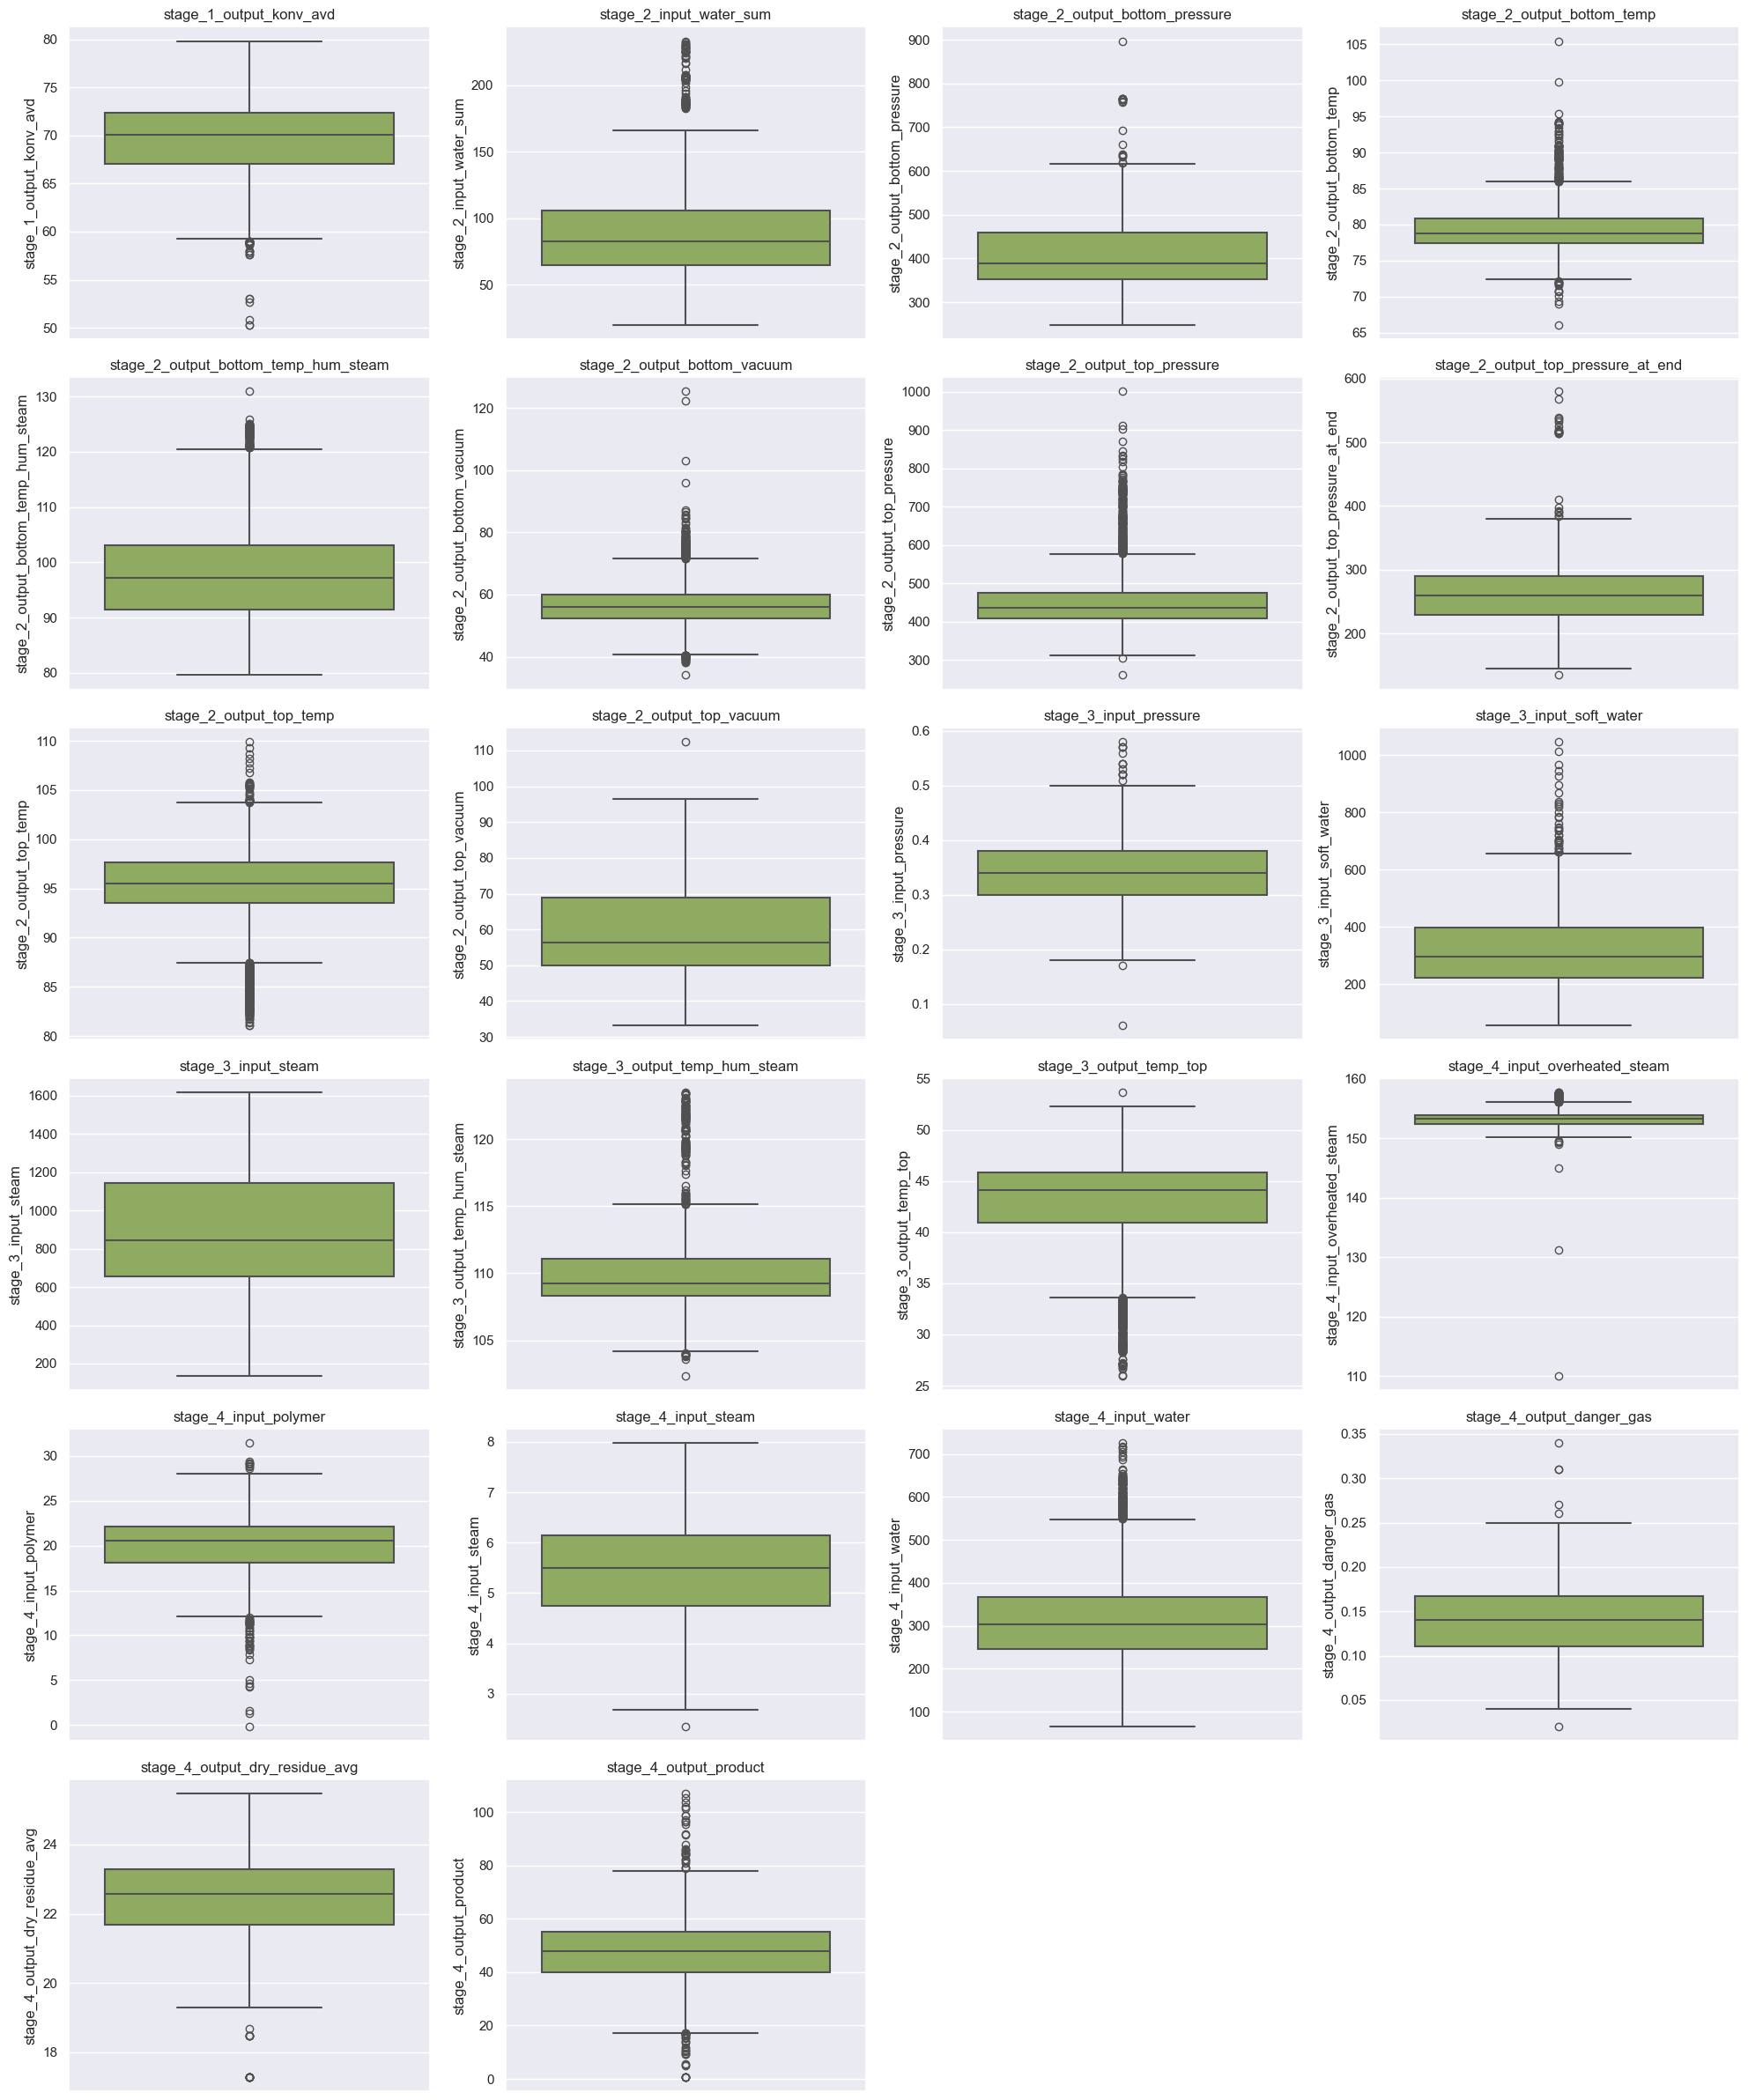

In [3510]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col], color=color_for_histplot, linewidth=1.5)
    plt.title(col)
    plt.tight_layout()

plt.show()

Разделяем на слабые (3 iqr) и супер (6 iqr) выбросы

При анализе показались странными выбросы:  
* stage_2_output_bottom_pressure >800  
* stage_2_output_bottom_temp_hum_steam > 130  
* stage_2_output_bottom_vacuum(нарушение) > 80  
* stage_2_output_top_pressure_at_end(нарушение) > 500  
* stage_2_output_top_vacuum(нарушение) > 80  
* stage_3_input_pressure(нарушение) < 0.1  
* stage_4_input_overheated_steam(нарушение) < 147  
* stage_4_input_polymer < 5  
* stage_4_output_dry_residue_avg < 18  
  
Проверим их, в случае если нет таргета (данных по газу) - удалим

Поменяем границы после которых начинаются странности в данных
* stage_1_output_konv_avd: нижняя граница - 67 и верхняя граница - 80  
* stage_2_input_water_sum: нижняя граница - 44 и верхняя граница - 240
* stage_2_output_bottom_pressure: нижняя граница - 240 и верхняя граница - 620  
* stage_2_output_bottom_temp: нижняя граница - 68 и верхняя граница - 94
* stage_2_output_bottom_temp_hum_steam: нижняя граница - 80 и верхняя граница - 124
* stage_2_output_bottom_vacuum: нижняя граница - 38 и верхняя граница - 85  
* stage_2_output_top_pressure: нижняя граница - 300 и верхняя граница - 800  
* stage_2_output_top_pressure_at_end: нижняя граница - 140 и верхняя граница - 400 
* stage_2_output_top_temp: нижняя граница - 82 и верхняя граница - 108  
* stage_2_output_top_vacuum: нижняя граница - 33 и верхняя граница - 97
* stage_3_input_pressure: нижняя граница - 0.19 и верхняя граница - 0.5  
* stage_3_input_soft_water: нижняя граница - 130 и верхняя граница - 810  
* stage_3_input_steam: нижняя граница - 100 и верхняя граница - 100  
* stage_3_output_temp_hum_steam: нижняя граница - 104 и верхняя граница - 1600  
* stage_3_output_temp_top: нижняя граница - 26 и верхняя граница - 53  
* stage_4_input_overheated_steam: нижняя граница - 149 и верхняя граница - 157 
* stage_4_input_polymer: нижняя граница - 7 и верхняя граница - 29  
* stage_4_input_water: нижняя граница - 50 и верхняя граница - 700  
* stage_4_output_danger_gas: нижняя граница - 0.04 и верхняя граница - 0.25  
* stage_4_output_dry_residue_avg: нижняя граница - 19 и верхняя граница - 25  
* stage_4_output_product: нижняя граница - 10 и верхняя граница - 100 


In [3511]:
df[df['stage_2_output_bottom_pressure'] > 800]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
3432  2022-06-19 04:00:00                    67.33                    61.36   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
3432                          897.29                      105.46   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
3432                                105.31                         73.73   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
3432                       830.38                              301.13   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
3432                   106.78  ...                         108.33   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
3432                    44.92                          152.95   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
3432                  13.72                 5.47                305.4   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
3432                        NaN                           22.98   

      stage_4_output_product  work_shift  
3432                   34.19         1.0  

[1 rows x 24 columns]

In [3512]:
df[df['stage_2_output_bottom_temp_hum_steam'] > 130]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
487  2021-03-11 08:00:00                    68.63                   113.72   

     stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
487                          470.37                       78.82   

     stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
487                                130.93                         54.25   

     stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
487                       394.83                              279.47   

     stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
487                    99.39  ...                         109.81   

     stage_3_output_temp_top  stage_4_input_overheated_steam  \
487                    41.15                          156.46   

     stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
487                   21.2                 6.08                222.1   

     stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
487                        NaN                           21.28   

     stage_4_output_product  work_shift  
487                   67.35         1.0  

[1 rows x 24 columns]

In [3513]:
df[df['stage_2_output_bottom_vacuum'] > 80]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
472   2021-03-02 11:00:00                    73.63                   117.51   
473   2021-03-02 13:00:00                    74.93                   114.79   
474   2021-03-02 14:00:00                    75.03                   111.95   
1108  2021-11-18 15:00:00                    60.63                   105.40   
1109  2021-11-18 16:00:00                    60.83                   133.72   
1110  2021-11-18 17:00:00                    62.83                      NaN   
1111  2021-11-18 18:00:00                    64.83                   124.28   
1112  2021-11-18 19:00:00                    64.83                   120.88   
1113  2021-11-18 20:00:00                    65.63                   117.48   
1114  2021-11-18 21:00:00                    65.83                   117.02   
1118  2021-11-19 01:00:00                    66.23                   125.21   
1119  2021-11-19 02:00:00                    66.33                   122.50   
1122  2021-11-19 05:00:00                    65.33                   123.46   
1123  2021-11-19 06:00:00                    64.33                   126.26   
1579  2021-12-08 23:00:00                    77.33                    35.85   
1742  2021-12-16 16:00:00                    70.33                    53.12   
2419  2022-02-24 15:00:00                    69.33                    92.63   
2420  2022-02-24 16:00:00                    69.63                    93.03   
3910  2022-08-04 16:00:00                    61.03                    53.51   
4369  2023-03-14 17:00:00                    67.23                    22.85   
4370  2023-03-14 18:00:00                    66.83                    22.64   
4371  2023-03-14 19:00:00                    66.83                    22.96   
4389  2023-03-15 13:00:00                    71.83                    23.28   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
472                           554.43                       85.77   
473                           660.03                       92.55   
474                           692.52                       95.39   
1108                          382.60                       81.07   
1109                          378.13                       80.81   
1110                          371.08                       79.72   
1111                          364.03                       78.62   
1112                          369.21                       79.49   
1113                          374.38                       80.37   
1114                          358.26                       78.80   
1118                          344.78                       78.29   
1119                          341.53                       78.02   
1122                          349.90                       78.87   
1123                          364.51                       79.97   
1579                          454.60                       85.09   
1742                          441.27                       84.17   
2419                          521.67                       87.12   
2420                          533.75                       89.02   
3910                          566.18                       86.59   
4369                          473.08                       85.57   
4370                          553.15                       90.03   
4371                          458.29                       84.49   
4389                          449.07                       84.92   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
472                                  94.68                         85.76   
473                                  98.14                        122.38   
474                                 101.40                        125.36   
1108                                 92.69                         87.29   
1109                                 91.26                         86.52   
1110                           

In [3514]:
df[df['stage_2_output_top_pressure_at_end'] > 500]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
829   2021-04-13 07:00:00                    68.03                    99.10   
830   2021-04-13 08:00:00                    68.03                    98.49   
831   2021-04-13 09:00:00                    65.93                    98.04   
832   2021-04-13 10:00:00                    65.03                    97.60   
833   2021-04-13 11:00:00                    65.03                   102.69   
834   2021-04-13 12:00:00                    65.63                   107.77   
838   2021-04-13 16:00:00                    68.33                   104.98   
839   2021-04-13 17:00:00                    68.73                   105.04   
840   2021-04-13 18:00:00                    69.03                   105.10   
841   2021-04-13 19:00:00                    69.03                   107.19   
842   2021-04-13 20:00:00                    69.03                   109.28   
843   2021-04-13 21:00:00                    68.93                   112.35   
844   2021-04-13 22:00:00                    68.83                   115.42   
845   2021-04-13 23:00:00                    68.83                   113.74   
846   2021-04-14 00:00:00                    68.83                   112.05   
2641  2022-03-17 08:00:00                    75.63                    68.73   
2642  2022-03-17 21:00:00                    74.83                    69.46   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
829                           477.45                       77.73   
830                           477.39                       77.74   
831                           478.73                       77.55   
832                           480.07                       77.37   
833                           481.32                       77.12   
834                           482.57                       76.88   
838                           484.95                       76.90   
839                           486.95                       76.77   
840                           488.94                       76.63   
841                           487.21                       76.68   
842                           485.49                       76.73   
843                           484.42                       76.85   
844                           483.35                       76.98   
845                           481.59                       76.67   
846                           479.83                       76.36   
2641                          329.93                       77.42   
2642                          346.06                       78.30   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
829                                  97.23                         58.86   
830                                  96.78                         58.81   
831                                  89.10                         59.36   
832                                  81.42                         59.91   
833                                  89.66                         58.29   
834                                  97.91                         56.67   
838                                  98.63                         55.84   
839                                  98.74                         55.51   
840                                  98.85                         55.18   
841                                  99.27                         55.33   
842                                  99.68                         55.48   
843                                 100.58                         55.64   
844                                 101.49                         55.79   
845                                 101.72                         55.23   
846                                 101.96                         54.66   
2641                                 85.40                         56.20   
2642                                 87.41                         59.53   



In [3515]:
df[df['stage_2_output_top_vacuum'] > 80]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
473   2021-03-02 13:00:00                    74.93                   114.79   
474   2021-03-02 14:00:00                    75.03                   111.95   
2624  2022-03-11 14:00:00                    71.33                    24.95   
2625  2022-03-11 15:00:00                    71.33                    32.43   
2627  2022-03-11 17:00:00                    71.23                    39.96   
...                   ...                      ...                      ...   
4050  2022-08-15 12:00:00                    65.33                    78.19   
4295  2022-11-13 20:00:00                    65.33                    61.24   
4296  2022-11-14 08:00:00                    63.83                    62.56   
4297  2022-11-14 20:00:00                    64.33                    53.68   
4298  2022-11-15 09:00:00                    64.73                    60.15   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
473                           660.03                       92.55   
474                           692.52                       95.39   
2624                          635.63                       94.32   
2625                          611.65                       94.17   
2627                          609.59                       94.04   
...                              ...                         ...   
4050                          431.87                       83.90   
4295                          346.77                       77.74   
4296                          396.76                       81.35   
4297                          339.99                       76.97   
4298                          324.22                       75.30   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
473                                  98.14                        122.38   
474                                 101.40                        125.36   
2624                                 99.36                         61.89   
2625                                 99.11                         55.75   
2627                                 98.96                         48.42   
...                                    ...                           ...   
4050                                110.21                         54.95   
4295                                 84.63                           NaN   
4296                                 82.64                         69.34   
4297                                 84.28                         56.18   
4298                                 84.79                         52.13   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
473                        767.24                              263.23   
474                        803.84                              363.62   
2624                       742.54                              317.97   
2625                       717.04                              252.75   
2627                       712.19                              215.05   
...                           ...                                 ...   
4050                       511.35                              223.53   
4295                       376.50                              276.97   
4296                       425.00                              345.29   
4297                       364.48                              278.28   
4298                       346.03                              259.66   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
473                     99.31  ...                         107.91   
474                    102.27  ...                         107.89   
2624                   103.88  ...                         110.60   
2625                   102.07  ...                         110.99   
2627                   100.28  ...                         111.38   
...                       ...  ...             

In [3516]:
df[df['stage_3_input_pressure'] < 0.1]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
3497  2022-07-15 02:00:00                    64.63                    69.46   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
3497                          336.89                       76.93   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
3497                                 87.41                         44.65   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
3497                       421.43                              160.75   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
3497                     84.5  ...                         102.33   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
3497                    43.19                          152.28   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
3497                  15.71                 5.25               249.56   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
3497                        NaN                           20.68   

      stage_4_output_product  work_shift  
3497                   47.91         2.0  

[1 rows x 24 columns]

In [3517]:
df[df['stage_4_input_overheated_steam'] < 147]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
2290  2022-02-12 12:00:00                    71.83                    62.69   
3456  2022-06-28 18:00:00                    72.33                    44.78   
3457  2022-06-28 19:00:00                    72.33                    59.14   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
2290                          334.45                       76.36   
3456                          277.50                       66.13   
3457                          290.80                       69.32   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
2290                                112.23                         51.60   
3456                                 81.60                         39.95   
3457                                 84.12                         41.69   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
2290                       427.14                              231.92   
3456                       438.93                              155.93   
3457                       471.81                              183.69   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
2290                    94.34  ...                         109.32   
3456                    83.29  ...                         105.77   
3457                    86.42  ...                         105.72   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
2290                    42.24                          144.98   
3456                    50.20                          110.04   
3457                    47.22                          131.16   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
2290                  20.69                 4.45               138.25   
3456                  11.86                 3.54               157.04   
3457                  11.59                 3.54               157.94   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
2290                       0.12                           22.08   
3456                        NaN                           21.98   
3457                        NaN                           21.98   

      stage_4_output_product  work_shift  
2290                   24.74         2.0  
3456                   33.22         2.0  
3457                   36.89         2.0  

[3 rows x 24 columns]

In [3518]:
df[df['stage_4_input_polymer'] < 5]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
473   2021-03-02 13:00:00                    74.93                   114.79   
529   2021-03-16 02:00:00                    74.03                    90.88   
775   2021-04-05 16:00:00                    71.03                   165.79   
1436  2021-12-02 14:00:00                      NaN                    70.29   
2626  2022-03-11 16:00:00                    71.33                    39.91   
4188  2022-09-29 13:00:00                    68.43                    90.94   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
473                           660.03                       92.55   
529                           433.48                       74.88   
775                           248.76                       70.69   
1436                          320.88                       75.06   
2626                          587.67                       94.03   
4188                          347.37                       75.82   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
473                                  98.14                        122.38   
529                                 117.87                         48.22   
775                                  91.95                         45.84   
1436                                100.19                         49.11   
2626                                 98.85                         49.62   
4188                                 87.39                         50.69   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
473                        767.24                              263.23   
529                        373.53                              279.29   
775                        260.22                              221.03   
1436                       390.72                              163.25   
2626                       691.54                              187.53   
4188                       567.14                              296.28   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
473                     99.31  ...                         107.91   
529                     97.27  ...                         108.79   
775                     97.43  ...                         107.56   
1436                    90.30  ...                         108.07   
2626                   100.26  ...                         111.38   
4188                    88.92  ...                         103.97   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
473                     49.24                          156.92   
529                     41.62                          156.76   
775                     49.82                          154.26   
1436                    49.10                          152.92   
2626                    39.07                          152.72   
4188                    44.86                          151.46   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
473                    4.25                 6.58               437.19   
529                    4.67                 4.52               222.52   
775                   -0.17                 4.05               215.97   
1436                   1.33                 5.95               318.12   
2626                   1.61                 4.30               358.90   
4188                   4.34                 2.35               446.27   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
473                        0.12                           22.18   
529                         NaN                           22.18   
775                         NaN                           22.58   
1436                        NaN                           22.28   
2626                        NaN                           22.88   
4188                        NaN                           20.08   

      stage_4_outpu

In [3519]:
df[df['stage_4_output_dry_residue_avg'] < 19]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
703   2021-03-29 14:00:00                    69.03                    81.59   
704   2021-03-29 15:00:00                    69.03                    80.99   
705   2021-03-29 16:00:00                    69.63                    80.39   
706   2021-03-29 17:00:00                    69.83                    80.53   
707   2021-03-29 18:00:00                    70.03                    80.67   
708   2021-03-29 19:00:00                    70.03                    81.65   
709   2021-03-29 20:00:00                    68.83                    82.64   
710   2021-03-29 21:00:00                    67.43                    82.94   
711   2021-03-29 22:00:00                    66.03                    83.25   
712   2021-03-29 23:00:00                    66.03                    81.82   
713   2021-03-30 00:00:00                    66.33                    80.39   
3464  2022-07-01 21:00:00                    61.23                    68.95   
3465  2022-07-02 08:00:00                    66.83                    70.02   
4189  2022-09-30 10:00:00                    66.63                    96.25   
4190  2022-09-30 11:00:00                    66.63                    96.75   
4191  2022-09-30 12:00:00                    66.33                    97.26   
4227  2022-10-14 12:00:00                      NaN                    57.99   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
703                           347.78                       77.10   
704                           334.39                       75.66   
705                           321.00                       74.22   
706                           339.78                       76.08   
707                           358.55                       77.93   
708                           354.33                       77.61   
709                           350.10                       77.30   
710                           345.70                       76.88   
711                           341.30                       76.46   
712                           366.08                       78.16   
713                           390.87                       79.86   
3464                          407.56                       80.88   
3465                          354.75                       77.46   
4189                          353.79                       79.39   
4190                          351.71                       79.18   
4191                          349.63                       78.96   
4227                          383.07                       80.29   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
703                                 119.81                         55.71   
704                                 118.96                         52.12   
705                                 118.11                         48.52   
706                                 119.30                         53.28   
707                                 120.49                         58.03   
708                                 116.10                         57.06   
709                                 111.72                         56.08   
710                                 107.17                         54.91   
711                                 102.62                         53.74   
712                                 103.05                         59.77   
713                                 103.48                         65.80   
3464                                 89.37                         68.86   
3465                                 86.92                         56.16   
4189                                113.40                         62.14   
4190                                114.30                         61.38   
4191                                115.21                         60.63   
4227                                100.90                         65.47   



In [3520]:
df = df[~(
    (
        (df['stage_2_output_bottom_pressure'] > 800) |
        (df['stage_2_output_bottom_temp_hum_steam'] > 130) |
        (df['stage_2_output_bottom_vacuum'] > 80) |
        (df['stage_2_output_top_pressure_at_end'] > 500) |
        (df['stage_2_output_top_vacuum'] > 80) |
        (df['stage_3_input_pressure'] < 0.1) |
        (df['stage_4_input_overheated_steam'] < 147) |
        (df['stage_4_input_polymer'] < 5) |
        (df['stage_4_output_dry_residue_avg'] < 19)
    ) & 
    (df['stage_4_output_danger_gas'].isna())
)]

Причины выбросов:  
* Давление - разгерметизация аппарата, > 101 кПа (Равно атмосферному)  
* Остальное - ошибки производства  
  
Количество выбросов в некоторых категориях большое, что говорит о том, что это нормальные условия протекания тех. процесса
Если мы их уберем, то потеряем существенную часть данных, из за чего мы не сможем дать правельный анализ

### Верхние и нижние границы

* stage_2_output_bottom_pressure < 800  
* stage_2_output_bottom_temp_hum_steam < 130  
* stage_2_output_bottom_vacuum(нарушение) < 80  
* stage_2_output_top_pressure_at_end(нарушение) < 500  
* stage_2_output_top_vacuum(нарушение) < 80  
* stage_3_input_pressure(нарушение) > 0.1  
* stage_4_input_overheated_steam(нарушение) > 147  
* stage_4_input_polymer > 5  
* stage_4_output_dry_residue_avg > 18  

###  Аналитический и графический анализ данных

Добавить границы значений. Сделать выводы.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

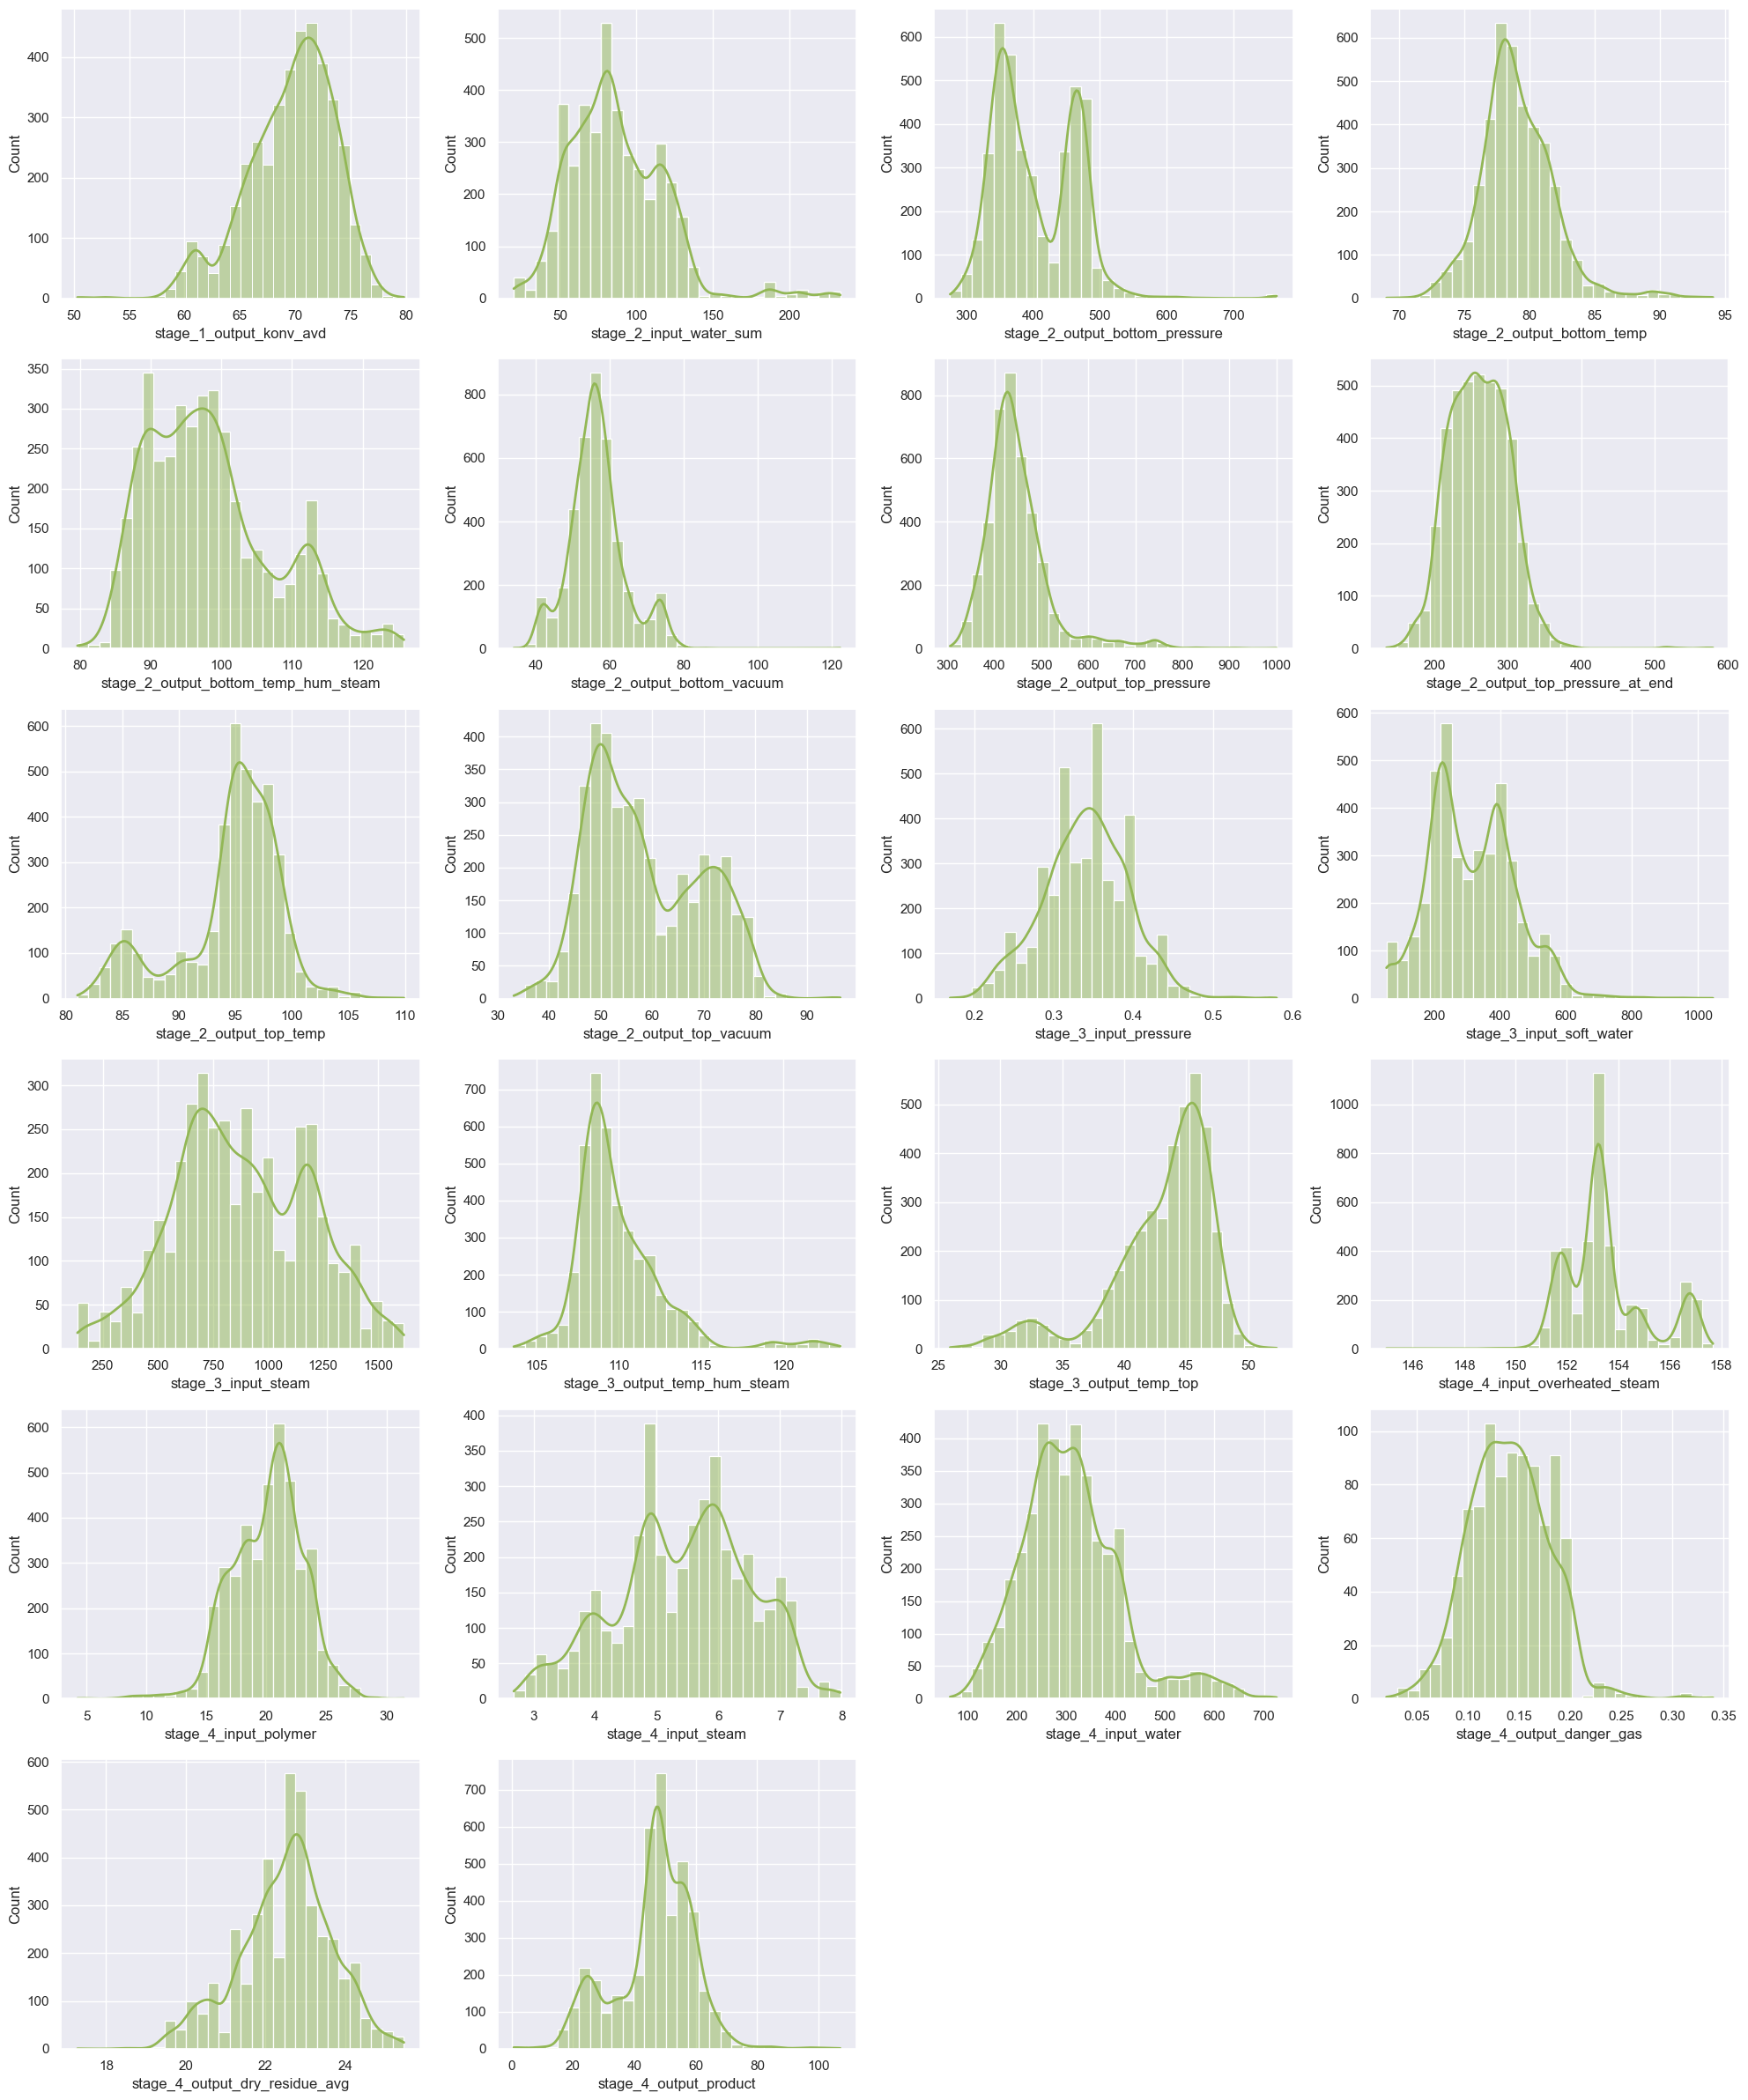

In [3521]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30, color=color_for_histplot, line_kws=line)
    plt.tight_layout()

plt.show()

### Составим сводную таблицу по часам для смен, чтобы посмотреть как менялись смены у сотрудников

In [3522]:
df_just_time = pd.DataFrame()
df_just_time['work_shift'] = df['work_shift']
df_just_time['time'] = df['datetime'].apply(lambda x: x.split(' ')[1].split(':')[0])
df_pivot_table = df_just_time.groupby('time')['work_shift'].value_counts()
df_pivot_table

time  work_shift
00    1.0            39
      2.0            34
01    1.0            83
      2.0            79
02    1.0            79
      2.0            78
03    1.0            80
      2.0            76
04    1.0            82
      2.0            79
05    1.0            81
      2.0            79
06    2.0            86
      1.0            83
07    2.0            84
      1.0            79
08    1.0           125
      2.0           113
09    1.0           107
      2.0           101
10    1.0            98
      2.0            88
11    1.0            94
      2.0            85
12    1.0           126
      2.0           114
13    1.0            90
      2.0            87
14    1.0            86
      2.0            75
15    1.0            76
      2.0            71
16    1.0            76
      2.0            70
17    1.0            75
      2.0            70
18    1.0            78
      2.0            77
19    2.0            76
      1.0            74
20    2.0           120

Видно, что по если смотерть по часам, то данные примерно одинаковы. Т.е смены идут не условно ночные/дневные, а чередуются как либо. Посмотрим в df как смены распределяются

In [3523]:
df[['datetime', 'work_shift']].head(19)

datetime  work_shift
0   2021-01-28 18:00:00         2.0
1   2021-01-28 19:00:00         2.0
2   2021-01-28 20:00:00         2.0
3   2021-01-28 21:00:00         2.0
4   2021-01-28 22:00:00         2.0
5   2021-01-28 23:00:00         2.0
6   2021-01-29 00:00:00         2.0
7   2021-01-29 01:00:00         2.0
8   2021-01-29 02:00:00         2.0
9   2021-01-29 03:00:00         2.0
10  2021-01-29 04:00:00         2.0
11  2021-01-29 05:00:00         2.0
12  2021-01-29 06:00:00         2.0
13  2021-01-29 07:00:00         2.0
14  2021-01-29 08:00:00         1.0
15  2021-01-29 09:00:00         1.0
16  2021-01-29 10:00:00         1.0
17  2021-01-29 11:00:00         1.0
18  2021-01-29 12:00:00         1.0

Делаем очевидный вывод. Смены сменяют друг друга в 8 утра каждый день. Если наш процесс идет 12 часов, то за смену мы успеваем проконтролировать/пронаблюдать 2 процесса, тогда при заполнении пропусков логичнее будет использовать интерполяциюю (учитывая последние 12 часов конкретного процесса)

### Пропуски

посмотрим сколько всего пропусков

In [3524]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                   75
stage_2_input_water_sum                   61
stage_2_output_bottom_pressure            59
stage_2_output_bottom_temp                31
stage_2_output_bottom_temp_hum_steam      15
stage_2_output_bottom_vacuum              71
stage_2_output_top_pressure               20
stage_2_output_top_pressure_at_end        14
stage_2_output_top_temp                   44
stage_2_output_top_vacuum                 35
stage_3_input_pressure                    74
stage_3_input_soft_water                  51
stage_3_input_steam                       11
stage_3_output_temp_hum_steam             13
stage_3_output_temp_top                   67
stage_4_input_overheated_steam             9
stage_4_input_polymer                     66
stage_4_input_steam                       82
stage_4_input_water                       80
stage_4_output_danger_gas               3158
stage_4_output_dry_residue_avg             0
stage_4_ou

посмотрим распределение всех данных, чтобы в целом оценить способы их замены. Т.к в случаех, если множество пропусков поряд стоит использовать либо среднее либо медиану.

In [3525]:

def raspder(x):
    koalit = []
    for i in x.columns:
        _, res = shapiro(x[i])
        if res >= 0.05:
            koalit.append([i, 'нормальное'])
        else:
            koalit.append([i, 'ненормальное'])
    return pd.DataFrame(koalit, columns=['Параметр', 'Распределение'])
print(raspder(df.drop('datetime', axis=1)))

                                Параметр Распределение
0                stage_1_output_konv_avd  ненормальное
1                stage_2_input_water_sum  ненормальное
2         stage_2_output_bottom_pressure  ненормальное
3             stage_2_output_bottom_temp  ненормальное
4   stage_2_output_bottom_temp_hum_steam  ненормальное
5           stage_2_output_bottom_vacuum  ненормальное
6            stage_2_output_top_pressure  ненормальное
7     stage_2_output_top_pressure_at_end  ненормальное
8                stage_2_output_top_temp  ненормальное
9              stage_2_output_top_vacuum  ненормальное
10                stage_3_input_pressure  ненормальное
11              stage_3_input_soft_water  ненормальное
12                   stage_3_input_steam  ненормальное
13         stage_3_output_temp_hum_steam  ненормальное
14               stage_3_output_temp_top  ненормальное
15        stage_4_input_overheated_steam  ненормальное
16                 stage_4_input_polymer  ненормальное
17        

In [3526]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                   75
stage_2_input_water_sum                   61
stage_2_output_bottom_pressure            59
stage_2_output_bottom_temp                31
stage_2_output_bottom_temp_hum_steam      15
stage_2_output_bottom_vacuum              71
stage_2_output_top_pressure               20
stage_2_output_top_pressure_at_end        14
stage_2_output_top_temp                   44
stage_2_output_top_vacuum                 35
stage_3_input_pressure                    74
stage_3_input_soft_water                  51
stage_3_input_steam                       11
stage_3_output_temp_hum_steam             13
stage_3_output_temp_top                   67
stage_4_input_overheated_steam             9
stage_4_input_polymer                     66
stage_4_input_steam                       82
stage_4_input_water                       80
stage_4_output_danger_gas               3158
stage_4_output_dry_residue_avg             0
stage_4_ou

Вывод: используем медиану если множество пропусков, в противном случаю интерполяцию за последние 12 часов. Первый процесс закачивается в 20:00. Второй в 8:00


In [3527]:
test_df = df.copy()

#if 
test_df['datetime'] = test_df['datetime'].astype("datetime64[ns]")
test_df['when_shift_start'] = test_df['datetime'].apply(lambda x: x.normalize() + pd.Timedelta(hours=8) if x.hour >= 8 else (x - pd.Timedelta(days=1)).normalize() + pd.Timedelta(hours=8))
test_df['num_of_prosess'] = test_df['datetime'].apply(lambda x: 2 if x.hour >= 20 else 1)
for i in test_df['when_shift_start'].unique():
    for q in range(1, 3):
        curr_test_df = test_df[(test_df['when_shift_start'] == i) & (test_df['num_of_prosess'] == q)]
        exclude_columns = ['datetime', 'when_shift_start', 'num_of_prosess', 'work_shift', 'stage_4_output_danger_gas']  # Столбцы, которые не трогаем
        for column in test_df.columns:
            if column not in exclude_columns:
                curr_test_df[column].interpolate(inplace=True)
        
        test_df[(test_df['when_shift_start'] == i) & (test_df['num_of_prosess'] == q)] = curr_test_df
test_df

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
df[numeric_cols] = test_df[numeric_cols]


C:\Users\Руслан\AppData\Local\Temp\ipykernel_15716\1253438642.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  curr_test_df[column].interpolate(inplace=True)
C:\Users\Руслан\AppData\Local\Temp\ipykernel_15716\1253438642.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_test_df[column].interpolate(inplace=True)
C:\Users\Руслан\AppDa

Index(['stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift'],
      dtype='object')


C:\Users\Руслан\AppData\Local\Temp\ipykernel_15716\1253438642.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  curr_test_df[column].interpolate(inplace=True)
C:\Users\Руслан\AppData\Local\Temp\ipykernel_15716\1253438642.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_test_df[column].interpolate(inplace=True)
C:\Users\Руслан\AppDa

In [3619]:
df.isna().sum()

datetime                                0
stage_1_output_konv_avd                 0
stage_2_input_water_sum                 0
stage_2_output_bottom_pressure          0
stage_2_output_bottom_temp              0
stage_2_output_bottom_temp_hum_steam    0
stage_2_output_bottom_vacuum            0
stage_2_output_top_pressure             0
stage_2_output_top_pressure_at_end      0
stage_2_output_top_temp                 0
stage_2_output_top_vacuum               0
stage_3_input_pressure                  0
stage_3_input_soft_water                0
stage_3_input_steam                     0
stage_3_output_temp_hum_steam           0
stage_3_output_temp_top                 0
stage_4_input_overheated_steam          0
stage_4_input_polymer                   0
stage_4_input_steam                     0
stage_4_input_water                     0
stage_4_output_danger_gas               0
stage_4_output_dry_residue_avg          0
stage_4_output_product                  0
work_shift                        

'stage_4_input_water' - подача воды, в м3  
Вероятно, ошибки или сбои, тк воду точно подавали, распределение не нормальное - используем медиану

In [3529]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].median())

310.38376872084456
301.41


'stage_4_input_polymer' - подача полимера, в м3  
Распределение не нормальное - используем медиану

In [3530]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())
df['stage_4_input_steam'].isna().sum()


5.430157016683022
5.54


0

'stage_4_input_overheated_steam' - подача перегретого пара, в м3  
Распределение не нормальное - используем медиану

In [3531]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].median())
df['stage_4_input_polymer'].isna().sum()

20.14692834433847
20.5


0

'stage_3_output_temp_top' - температура верха в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану

In [3532]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].median())
df['stage_4_input_overheated_steam'].isna().sum()

153.48968467367393
153.22


0

'stage_3_output_temp_hum_steam' - температура насыщенного пара, в градусах Цельсия  
Распределение не нормальное - используем медиану

In [3533]:
print(df['stage_3_output_temp_top'].mean())
print(df['stage_3_output_temp_top'].median())
df['stage_3_output_temp_top'] = df['stage_3_output_temp_top'].fillna(df['stage_3_output_temp_top'].median())

42.957174552586416
44.16


'stage_3_input_steam'- подаваемый пар, в м3  
Распределение не нормальное - используем медиану 

In [3534]:
print(df['stage_3_output_temp_hum_steam'].mean())
print(df['stage_3_output_temp_hum_steam'].median())
df['stage_3_output_temp_hum_steam'] = df['stage_3_output_temp_hum_steam'].fillna(df['stage_3_output_temp_hum_steam'].median())

109.9961451967734
109.24


'stage_3_input_soft_water' - подаваемая смягченная вода, в м3  
Распределение не нормальное - используем медиану

In [3535]:
print(df['stage_3_input_soft_water'].mean())
print(df['stage_3_input_soft_water'].median())
df['stage_3_input_soft_water'] = df['stage_3_input_soft_water'].fillna(df['stage_3_input_soft_water'].median())

314.7679862812347
297.66499999999996


'stage_3_input_pressure' - подаваемое давление в агрегат, в кПа  
Распределение не нормальное - используем медиану

In [3536]:
print(df['stage_3_input_pressure'].mean())
print(df['stage_3_input_pressure'].median())
df['stage_3_input_pressure'] = df['stage_3_input_pressure'].fillna(df['stage_3_input_pressure'].median())

0.3401176759009561
0.34


'stage_2_output_top_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану

In [3537]:
print(df['stage_2_output_top_vacuum'].mean())
print(df['stage_2_output_top_vacuum'].median())
df['stage_2_output_top_vacuum'] = df['stage_2_output_top_vacuum'].fillna(df['stage_2_output_top_vacuum'].median())

58.51025556370751
56.22


'stage_2_output_top_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

In [3538]:
print(df['stage_2_output_top_temp'].mean())
print(df['stage_2_output_top_temp'].median())
df['stage_2_output_top_temp'] = df['stage_2_output_top_temp'].fillna(df['stage_2_output_top_temp'].median())

94.5554712362301
95.48


'stage_2_output_top_pressure_at_end' - давление верха в агрегате на выходе, в кПа  
Распределение почти нормальное - используем среднее 

In [3539]:
print(df['stage_2_output_top_pressure_at_end'].mean())
print(df['stage_2_output_top_pressure_at_end'].median())
df['stage_2_output_top_pressure_at_end'] = df['stage_2_output_top_pressure_at_end'].fillna(df['stage_2_output_top_pressure_at_end'].mean())

261.35821917808215
260.49


'stage_2_output_top_pressure' - давление верха (top) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

In [3540]:

print(df['stage_2_output_top_pressure'].mean())
print(df['stage_2_output_top_pressure'].median())
df['stage_2_output_top_pressure'] = df['stage_2_output_top_pressure'].fillna(df['stage_2_output_top_pressure'].median())

448.2307440039158
435.6375


'stage_2_output_bottom_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану 

In [3541]:

print(df['stage_2_output_bottom_vacuum'].mean())
print(df['stage_2_output_bottom_vacuum'].median())
df['stage_2_output_bottom_vacuum'] = df['stage_2_output_bottom_vacuum'].fillna(df['stage_2_output_bottom_vacuum'].median())

56.66094893199116
56.08


'stage_2_output_bottom_temp_hum_steam' - температура насыщенного пара низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

In [3542]:
print(df['stage_2_output_bottom_temp_hum_steam'].mean())
print(df['stage_2_output_bottom_temp_hum_steam'].median())
df['stage_2_output_bottom_temp_hum_steam'] = df['stage_2_output_bottom_temp_hum_steam'].fillna(df['stage_2_output_bottom_temp_hum_steam'].median())

98.37199388753056
96.96


'stage_2_output_bottom_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение нормальное - используем среднее

In [3543]:
print(df['stage_2_output_bottom_temp'].mean())
print(df['stage_2_output_bottom_temp'].median())
df['stage_2_output_bottom_temp'] = df['stage_2_output_bottom_temp'].fillna(df['stage_2_output_bottom_temp'].mean())

79.09061873318659
78.75


'stage_2_output_bottom_pressure' - давление низа (bottom) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

In [3544]:
print(df['stage_2_output_bottom_pressure'].mean())
print(df['stage_2_output_bottom_pressure'].median())
df['stage_2_output_bottom_pressure'] = df['stage_2_output_bottom_pressure'].fillna(df['stage_2_output_bottom_pressure'].median())

402.85544809010776
387.51


'stage_2_input_water_sum' - количество подаваемой суммарной воды в агрегат, в м3.

Распределение не нормальное - используем медиану 

In [3545]:
print(df['stage_2_input_water_sum'].mean())
print(df['stage_2_input_water_sum'].median())
df['stage_2_input_water_sum'] = df['stage_2_input_water_sum'].fillna(df['stage_2_input_water_sum'].median())

87.02092424613875
83.06


'stage_1_output_konv_avd' - процент конверсии сырья в мономер.  
Различия медианы и среднего мало, распределение выглядит почти нормальным, можно брать и среднее и медиану

In [3546]:
print(df['stage_1_output_konv_avd'].mean())
print(df['stage_1_output_konv_avd'].median())
df['stage_1_output_konv_avd'] = df['stage_1_output_konv_avd'].fillna(df['stage_1_output_konv_avd'].mean())

69.62982859941233
70.155


## Проведение расчётов

In [3547]:
df['datetime'] = df['datetime'].apply(lambda x: x.split(' ')[0])

### Категория опасности 

In [3548]:
df['danger_gas_kat'] = df['stage_4_output_danger_gas'].apply(
    lambda x: None if pd.isna(x) else (1 if x < 0.05 else (2 if x < 0.16 else 3))
)

df.columns

Index(['datetime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift', 'danger_gas_kat'],
      dtype='object')

###  Cводная таблица изменения параметров сгруппированная по дням 

In [3549]:
df['input_water_sum'] = df['stage_2_input_water_sum'] + df['stage_4_input_water'] + df['stage_3_input_soft_water']
df['input_steam_sum'] = df['stage_4_input_steam'] + df['stage_3_input_steam']

columns_to_sum = ['stage_4_input_overheated_steam', 'stage_4_input_polymer', 'input_water_sum', 'input_steam_sum']

pivot_df = df.groupby('datetime')[columns_to_sum].sum()

pressure_avg = df.groupby('datetime')['stage_3_input_pressure'].mean().reset_index()
pivot_df = pd.merge(pivot_df, pressure_avg, on='datetime', how='left')
df.drop(columns=['input_water_sum', 'input_steam_sum'], inplace=True, axis=1)
pivot_df

datetime  stage_4_input_overheated_steam  stage_4_input_polymer  \
0    2021-01-28                          938.81                117.740   
1    2021-01-29                         2661.56                312.330   
2    2021-01-30                          784.46                113.960   
3    2021-01-31                         2193.40                356.290   
4    2021-02-01                         2352.30                355.915   
..          ...                             ...                    ...   
366  2023-03-17                          304.02                 38.450   
367  2023-03-18                          153.93                 17.020   
368  2023-03-19                          152.90                 22.690   
369  2023-03-20                          305.06                 43.160   
370  2023-03-21                          304.81                 44.120   

     input_water_sum  input_steam_sum  stage_3_input_pressure  
0           5201.460          4265.89                0.348333  
1          14085.260         11674.59                0.352353  
2           4587.810          4163.24                0.404000  
3          13584.480         12648.82                0.384286  
4          14701.525         12277.10                0.378667  
..               ...              ...                     ...  
366         1103.380          1046.11                0.365000  
367          667.120           418.11                0.540000  
368          531.710           451.57                0.460000  
369         1130.310          1069.08                0.360000  
370         1298.780          1041.74                0.355000  

[371 rows x 6 columns]

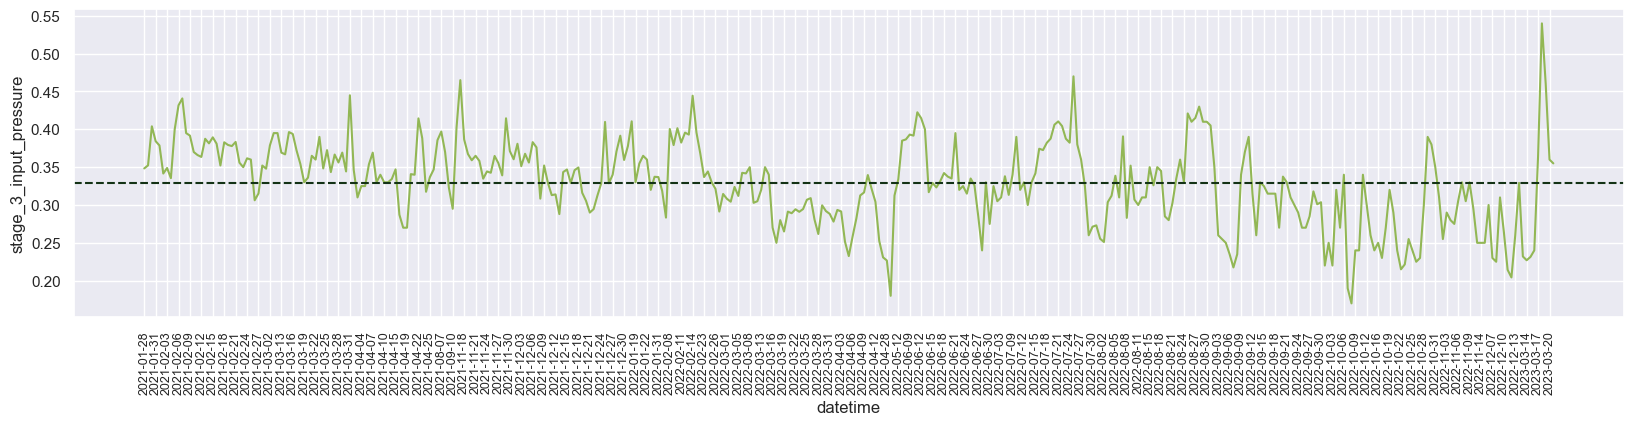

In [3550]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_3_input_pressure', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_3_input_pressure'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

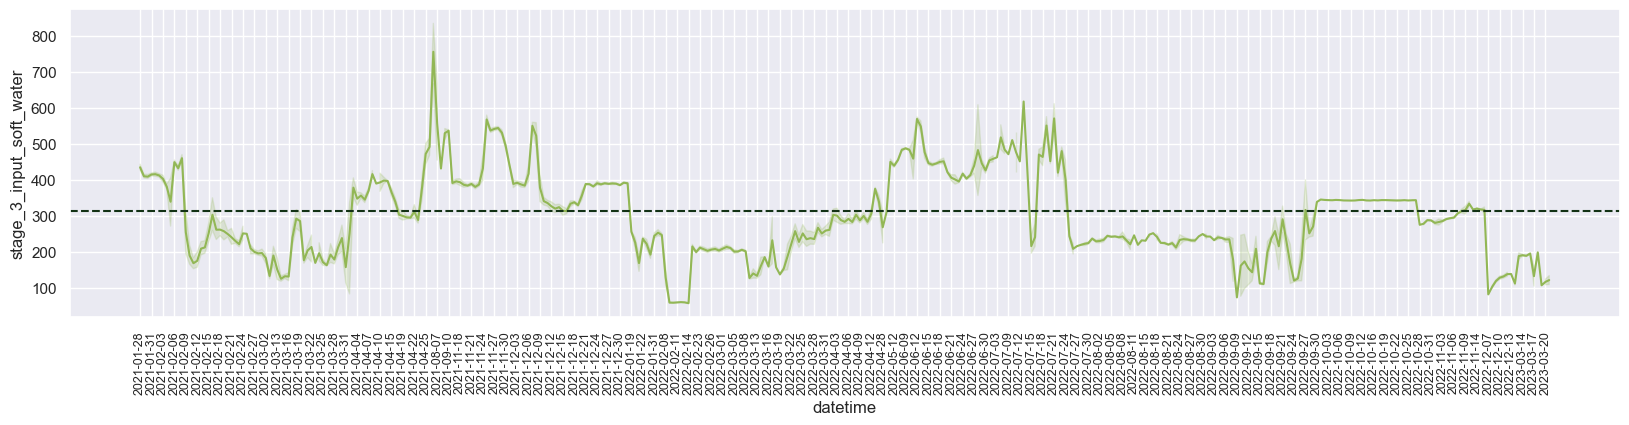

In [3551]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_3_input_soft_water', data=df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = df['stage_3_input_soft_water'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

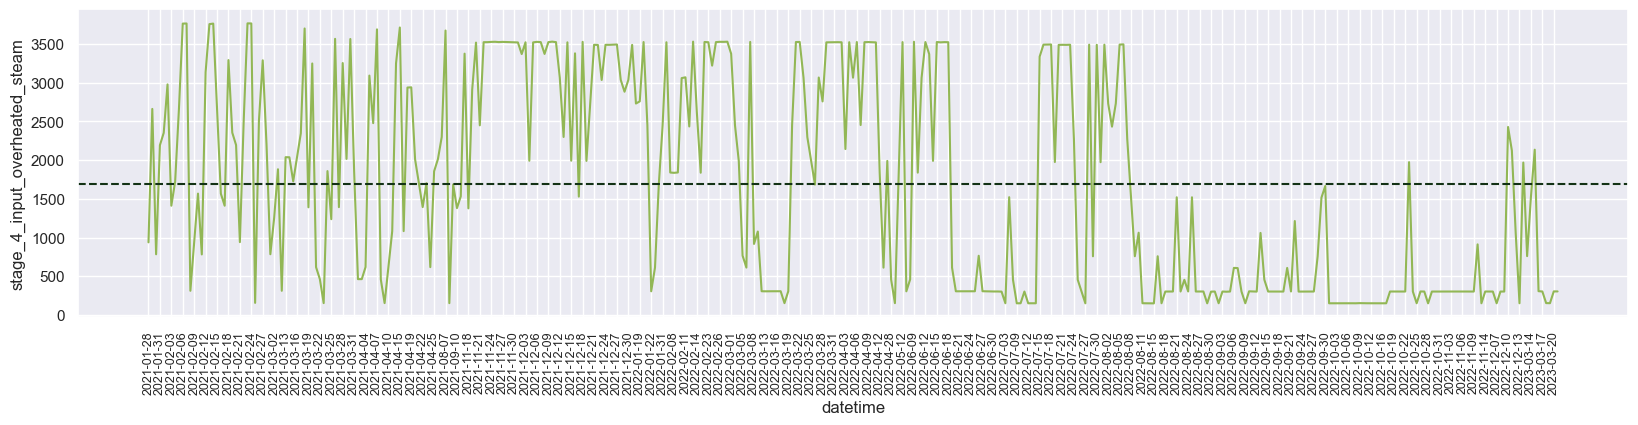

In [3552]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_overheated_steam'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

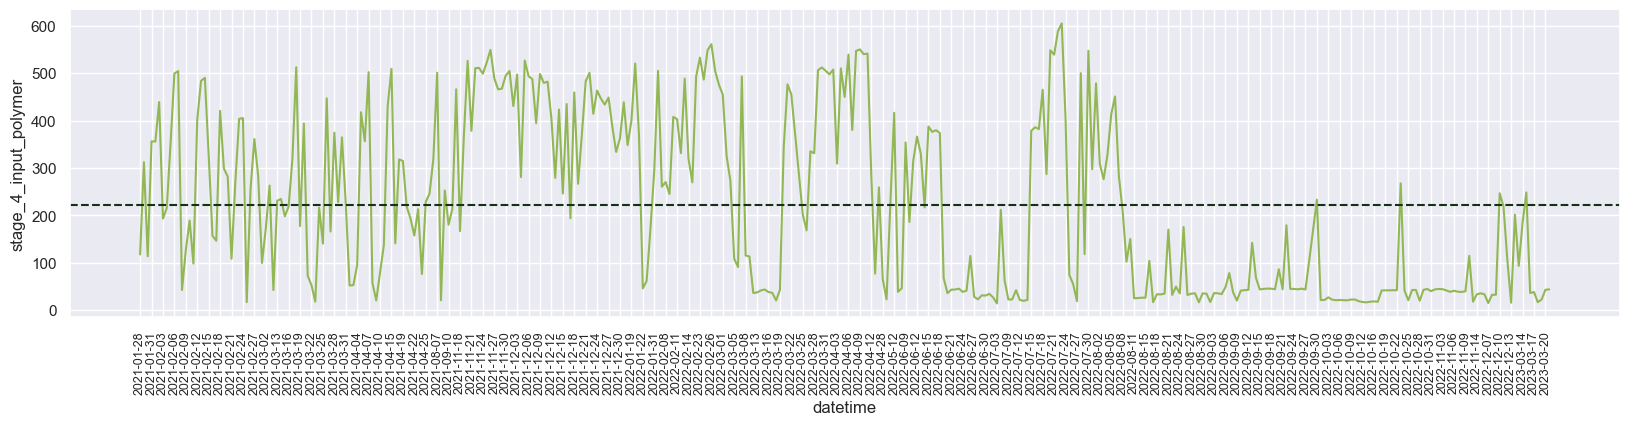

In [3553]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_polymer', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_polymer'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

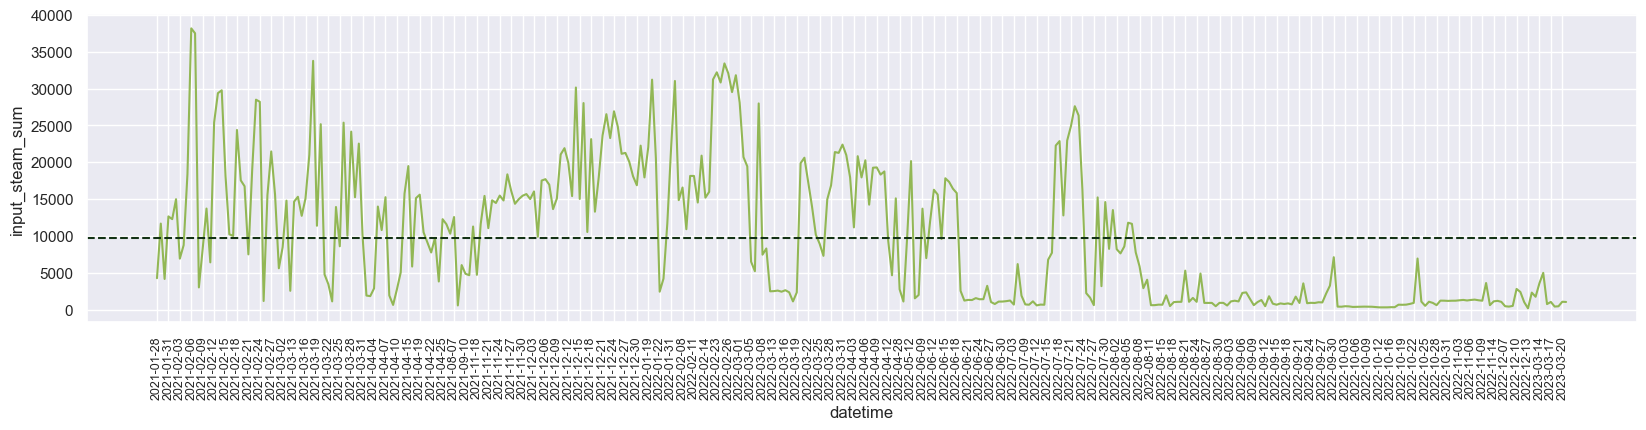

In [3554]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_steam_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_steam_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

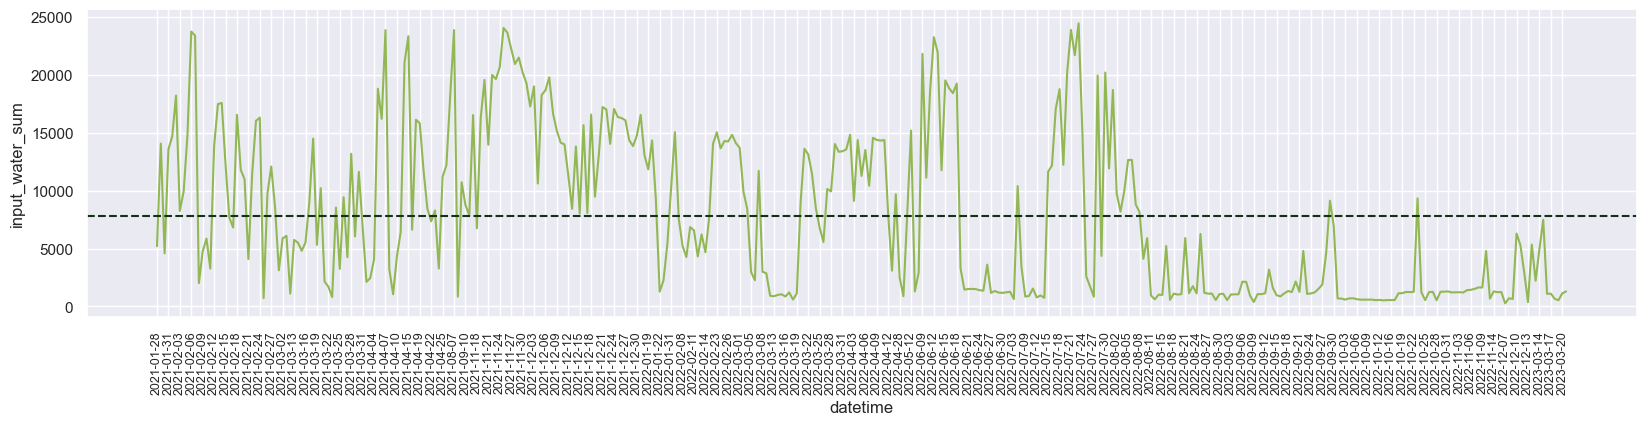

In [3555]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_water_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3])

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_water_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

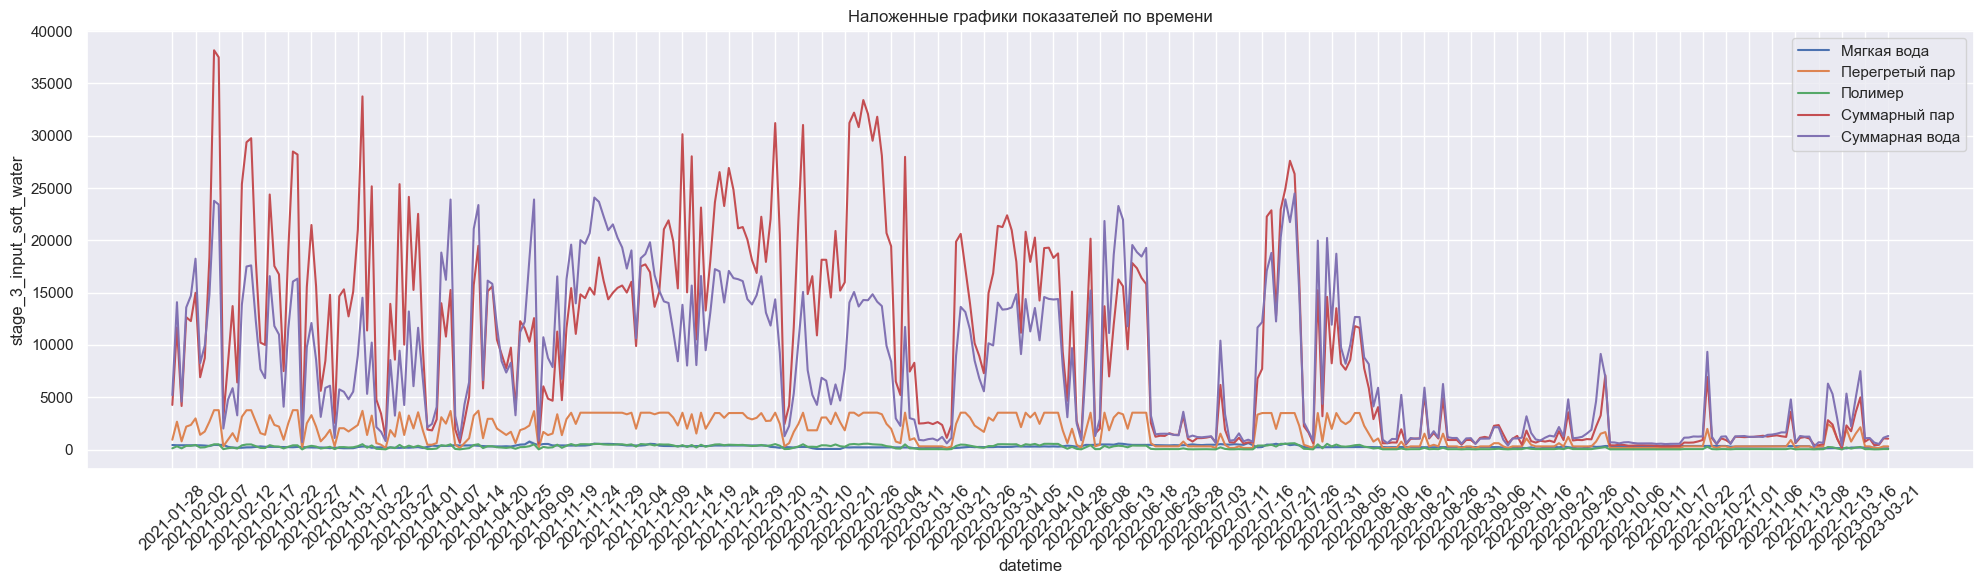

In [3556]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(x='datetime', y='stage_3_input_soft_water', data=df, label='Мягкая вода', ax=ax)
sns.lineplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_df, label='Перегретый пар', ax=ax)
sns.lineplot(x='datetime', y='stage_4_input_polymer', data=pivot_df, label='Полимер', ax=ax)
sns.lineplot(x='datetime', y='input_steam_sum', data=pivot_df, label='Суммарный пар', ax=ax)
sns.lineplot(x='datetime', y='input_water_sum', data=pivot_df, label='Суммарная вода', ax=ax)

ax.set_xticks(ax.get_xticks()[::5])
plt.xticks(rotation=45, fontsize=12)

plt.legend()
plt.title('Наложенные графики показателей по времени')
plt.tight_layout()
plt.show()



Дневной расход ресурсов колеблеца постоянно, что говорит о нестбильности производства.  
К концу 2022 года (август) колебания умельнишились, что говорит о стабилизации процесса  
  
В среднем компания тратила больше ресурсов (продолжительном периоде) с 2021.08 до 2022.01  
Так же тратилось много (но меньше) ресурсов в период с 2022.03 до 2022.06

### Cводная таблица изменения категории опасности сгруппированная по месяцам

Обработаем даты

In [3557]:
df['datetime'] = df['datetime'].apply(lambda x: x[:-3])

In [3558]:
for_table_df = df[['datetime', 'danger_gas_kat']]

for_table_df = for_table_df.groupby(['datetime'], as_index=False).value_counts()
pivot_table = for_table_df.pivot_table(index='datetime', aggfunc=mode)
pivot_table['danger_gas_kat'] = pivot_table['danger_gas_kat'].astype('int')
pivot_table

count  danger_gas_kat
datetime                       
2021-01       5               2
2021-02      50               2
2021-03      59               2
2021-04      33               2
2021-08       8               2
2021-09       3               2
2021-11      32               2
2021-12      54               3
2022-01      11               3
2022-02      36               2
2022-03      40               2
2022-04      38               2
2022-05       4               2
2022-06      46               2
2022-07      52               2
2022-08      32               2
2022-09      47               2
2022-10      29               2
2022-11      16               2
2022-12       8               2
2023-03      10               3

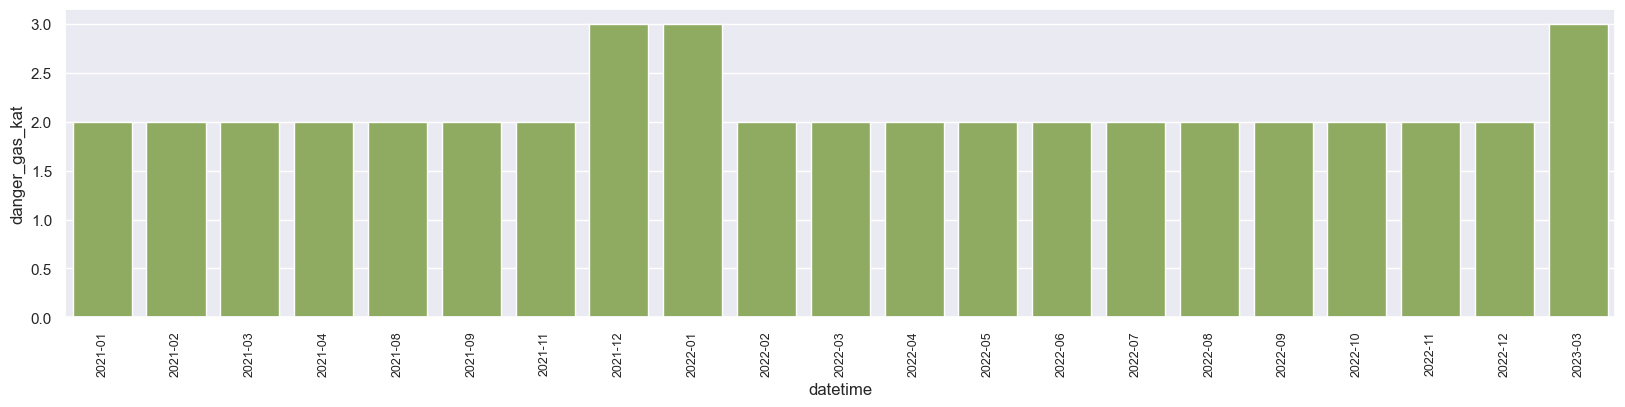

In [3559]:
plt.figure(figsize=(20, 4))

graph = sns.barplot(x='datetime', y='danger_gas_kat', data=pivot_table, color=color_for_histplot)

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
plt.show()

Наибольшая опасность была в период с 2021.12 - 2022.01 и 2023.03

### Среднее значение каждого параметра для каждой категории

In [3560]:
curr_df = df.copy()

curr_df.drop(['datetime', 'work_shift'], axis=1, inplace=True)

group = curr_df.groupby(['danger_gas_kat']).mean()
group

stage_1_output_konv_avd  stage_2_input_water_sum  \
danger_gas_kat                                                     
1.0                           65.830000                80.640000   
2.0                           68.973091                87.832566   
3.0                           69.338878                86.472124   

                stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
danger_gas_kat                                                               
1.0                                 383.996000                   78.536000   
2.0                                 395.180049                   79.071448   
3.0                                 396.057695                   78.742850   

                stage_2_output_bottom_temp_hum_steam  \
danger_gas_kat                                         
1.0                                       101.944000   
2.0                                        98.325403   
3.0                                        97.468785   

                stage_2_output_bottom_vacuum  stage_2_output_top_pressure  \
danger_gas_kat                                                              
1.0                                56.360000                   450.904000   
2.0                                56.612352                   458.060617   
3.0                                56.763629                   443.590771   

                stage_2_output_top_pressure_at_end  stage_2_output_top_temp  \
danger_gas_kat                                                                
1.0                                     266.380000                93.890000   
2.0                                     262.250096                94.333553   
3.0                                     263.886760                94.933816   

                stage_2_output_top_vacuum  ...  stage_3_input_steam  \
danger_gas_kat                             ...                        
1.0                             58.212000  ...           756.620000   
2.0                             59.387829  ...           815.876645   
3.0                             56.929237  ...           837.982150   

                stage_3_output_temp_hum_steam  stage_3_output_temp_top  \
danger_gas_kat                                                           
1.0                                109.586000                41.268000   
2.0                                109.370403                42.196891   
3.0                                109.970218                42.495421   

                stage_4_input_overheated_steam  stage_4_input_polymer  \
danger_gas_kat                                                          
1.0                                 153.314000              18.092000   
2.0                                 153.348141              20.084301   
3.0                                 153.236044              20.168956   

                stage_4_input_steam  stage_4_input_water  \
danger_gas_kat                                             
1.0                        4.612000            232.05000   
2.0                        5.217163            297.56477   
3.0                        5.597788            312.85352   

                stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
danger_gas_kat                                                              
1.0                              0.036000                       21.800000   
2.0                              0.119079                       22.222434   
3.0                              0.181651                       22.525171   

                stage_4_output_product  
danger_gas_kat                          
1.0                          43.484000  
2.0                          44.234852  
3.0                          42.330779  

[3 rows x 22 columns]

### Корреляционный анализ

<Axes: >

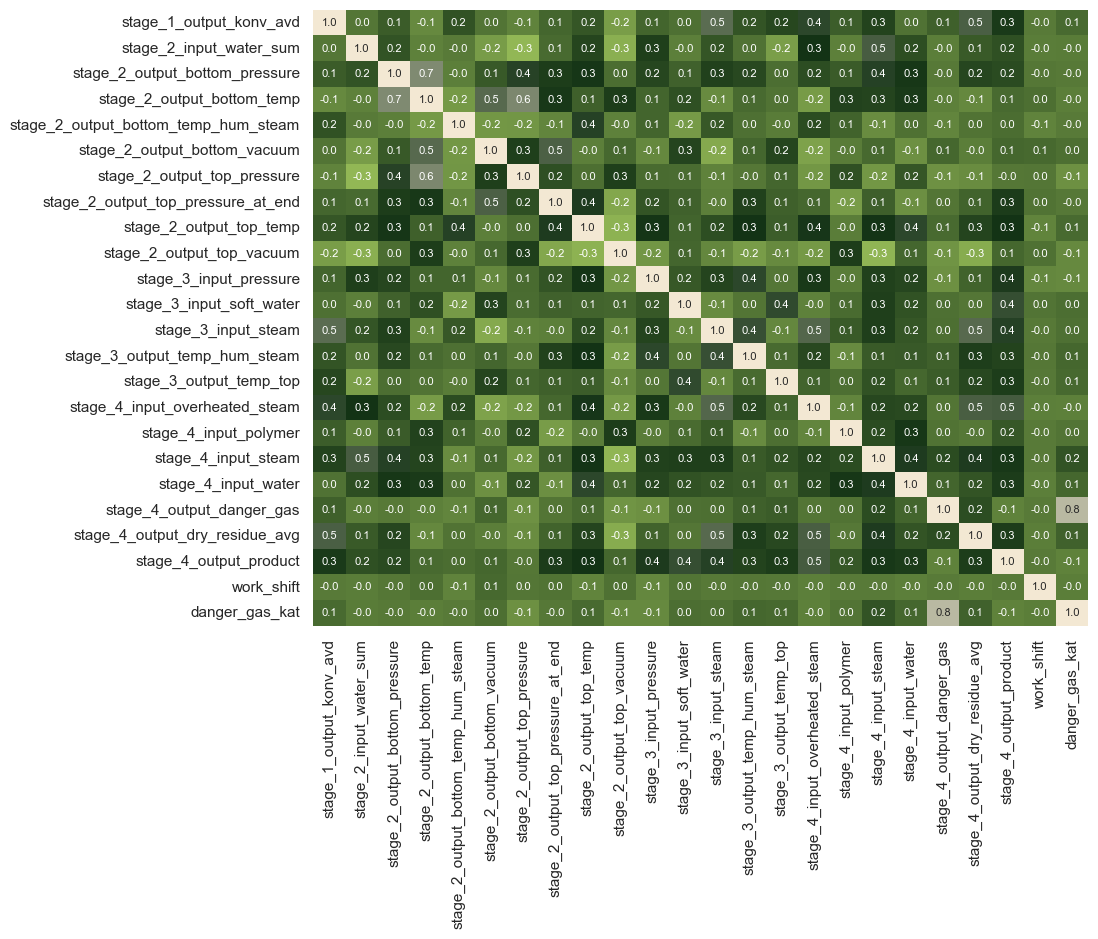

In [3561]:
df_filtered = df.dropna(subset=['stage_4_output_danger_gas'])
custom_gradient = LinearSegmentedColormap.from_list("CorporateGradient", corporate_colors)
spec_df = df_filtered.drop('datetime', axis=1)
correlation_matrix = spec_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap=custom_gradient, fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})


## Проверка гипотез

Функция для проверки нормольности распределения данных

In [3562]:
def raspder(x):
    koalit = []
    for i in x.columns:
        _, res = shapiro(x[i])
        if res >= 0.05:
            koalit.append([i, 'нормальное'])
        else:
            koalit.append([i, 'ненормальное'])
    return pd.DataFrame(koalit, columns=['Параметр', 'Распределение'])

### Гипотеза 1. Если ли различия в доле опасного газа от смены?

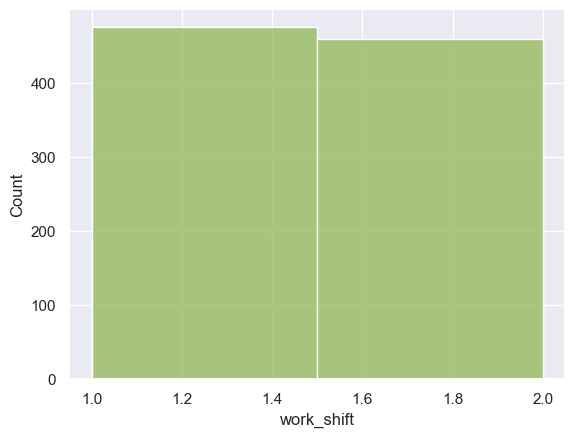

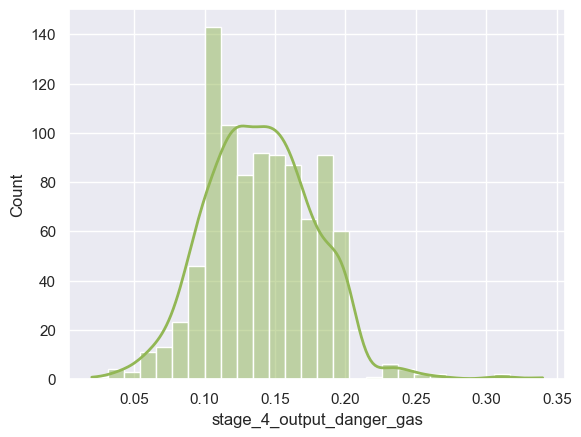

In [3563]:
cor_df = df[['work_shift', 'stage_4_output_danger_gas']].copy()
cor_df = cor_df.dropna(subset=['stage_4_output_danger_gas']).reset_index(drop=True)
cor_df['work_shift'] = cor_df['work_shift'].astype(int)

sns.histplot(cor_df['work_shift'], bins=2, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(cor_df['stage_4_output_danger_gas'], kde=True, color=color_for_histplot, line_kws=line)
plt.show()

In [3564]:
raspder(cor_df)

Параметр Распределение
0                 work_shift  ненормальное
1  stage_4_output_danger_gas  ненормальное

#### Составим гипотезы
H₀ = Между work_shift и stage_4_output_danger_gas нет различий в доле опасного газа от смены

H₁ = Между work_shift и stage_4_output_danger_gas существует различия в доле опасного газа от смены 

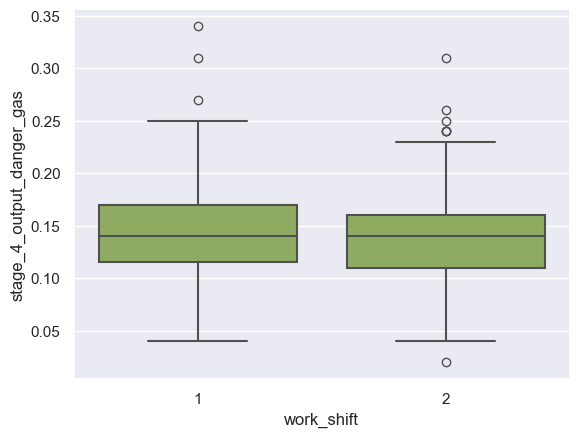

Коэффициент корреляции(static): -0.0158
P-уровень: 0.6302


In [3565]:
sns.boxplot(x='work_shift', y='stage_4_output_danger_gas', data=cor_df, color=color_for_histplot, linewidth=1.5)
plt.show()
corr, p_value = pointbiserialr(cor_df['work_shift'], cor_df['stage_4_output_danger_gas']) # разновидность корреляции Пирсона
print(f"Коэффициент корреляции(static): {corr:.4f}")
print(f"P-уровень: {p_value:.4f}")


Значение P-уровня > 0.05, т.е нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Если различия и есть, то они носят случайный характер

### Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3?

In [3566]:
cor_df = df[['work_shift', 'stage_3_output_temp_top']].copy()
df['work_shift'] = cor_df['work_shift'].astype(int)

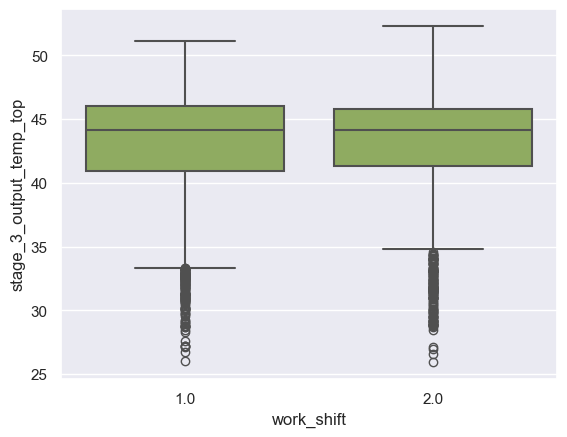

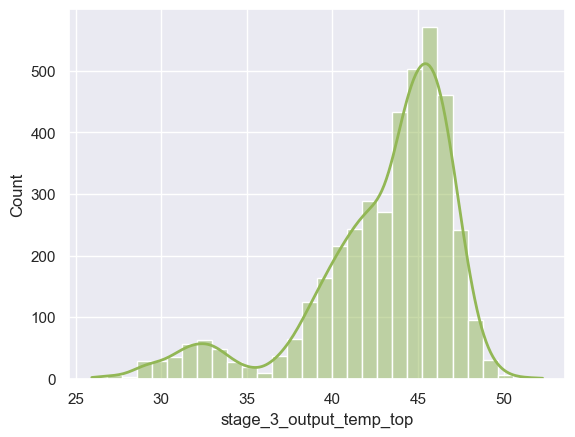

In [3567]:
sns.boxplot(x='work_shift', y='stage_3_output_temp_top', data=cor_df, color=color_for_histplot, linewidth=1.5)
plt.show()
sns.histplot(cor_df['stage_3_output_temp_top'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3568]:
raspder(cor_df)

Параметр Распределение
0               work_shift  ненормальное
1  stage_3_output_temp_top  ненормальное

#### Составим гипотезы
H₀ = Нет различий в температуре верха между сменами.  

H₁ = Температура верха отличается между сменами.  

In [3569]:
cor, p_value = pointbiserialr(cor_df['work_shift'], cor_df['stage_3_output_temp_top'])
print(f"Корреляция: {cor}")
print(f"P-значение: {p_value}")

Корреляция: 0.008012919585292495
P-значение: 0.6083514894495344


P-уровень: 0.642 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Т.е если различия между температурами верхов носят случайный характер

### Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

In [3570]:
gip_3 = df[['stage_1_output_konv_avd', 'stage_2_input_water_sum' ]]
gip_3.head()

stage_1_output_konv_avd  stage_2_input_water_sum
0                    67.83                    92.99
1                    67.83                    91.82
2                    67.83                    90.65
3                    67.93                    90.24
4                    68.03                    89.84

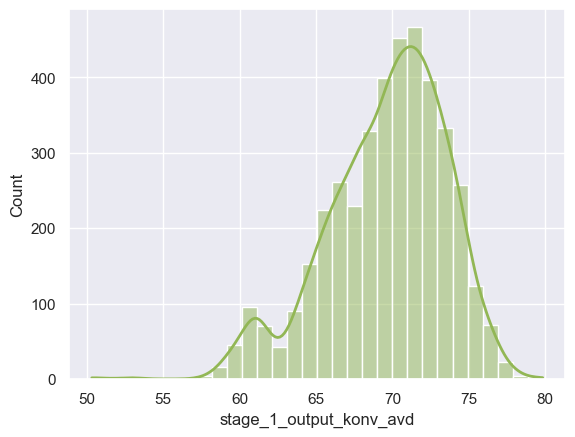

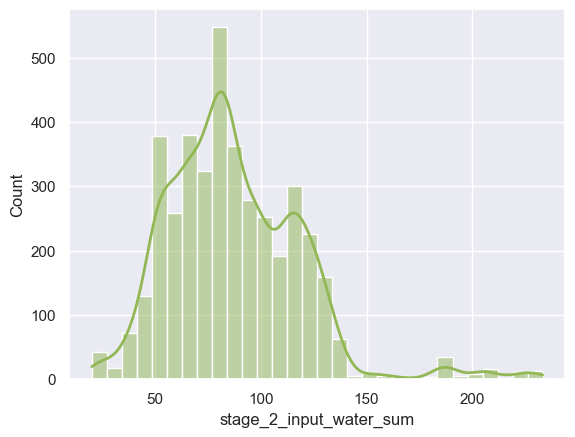

In [3571]:
sns.histplot(gip_3['stage_1_output_konv_avd'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_3['stage_2_input_water_sum'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

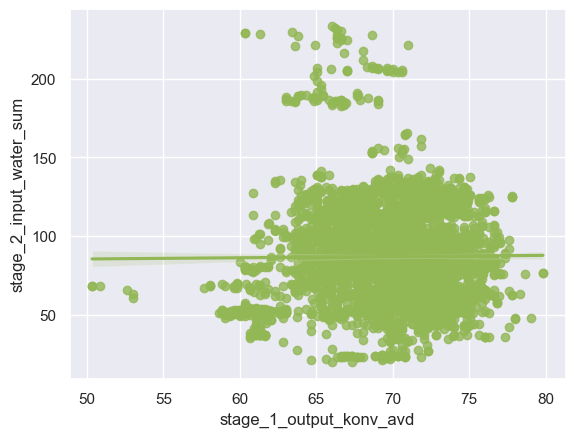

In [3572]:
sns.regplot(x='stage_1_output_konv_avd', y='stage_2_input_water_sum', data=gip_3, color=color_for_histplot)
plt.show()

Т.к линия горизонтальная, то можно сказать что значение корреляции стремится к 0

In [3573]:
raspder(gip_3)

Параметр Распределение
0  stage_1_output_konv_avd  ненормальное
1  stage_2_input_water_sum  ненормальное

#### Составим гипотезы
H₀ = Между stage_1_output_konv_avd и stage_2_input_water_sum нет линейной связи  

H₁ = Между stage_1_output_konv_avd и stage_2_input_water_sum существует линейная связь  

In [3574]:
cor, p_value = spearmanr(gip_3['stage_1_output_konv_avd'], gip_3['stage_2_input_water_sum'])
print(f"Корреляция: {cor}")
print(f"P-значение: {p_value}")

Корреляция: -0.0005962976429858336
P-значение: 0.9695818316573799


P-уровень: 0.97191 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Получается, между stage_1_output_konv_avd не влияет на stage_2_input_water_sum

### Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа

In [3575]:
gip_4 = df[['stage_4_output_product', 'stage_4_output_danger_gas']]
gip_4 = gip_4.dropna(subset=['stage_4_output_danger_gas']).reset_index(drop=True)
gip_4.head()

stage_4_output_product  stage_4_output_danger_gas
0                   46.01                       0.16
1                   52.55                       0.15
2                   42.99                       0.13
3                   43.67                       0.14
4                   47.43                       0.15

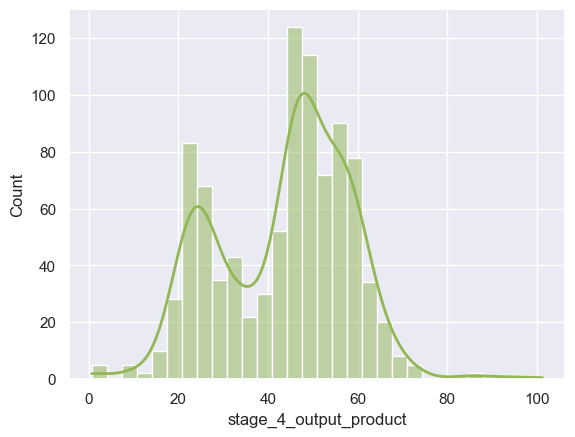

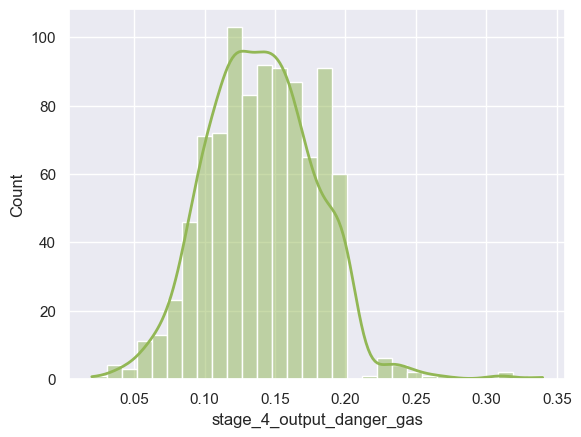

In [3576]:
sns.histplot(gip_4['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_4['stage_4_output_danger_gas'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3577]:
raspder(gip_4)

Параметр Распределение
0     stage_4_output_product  ненормальное
1  stage_4_output_danger_gas  ненормальное

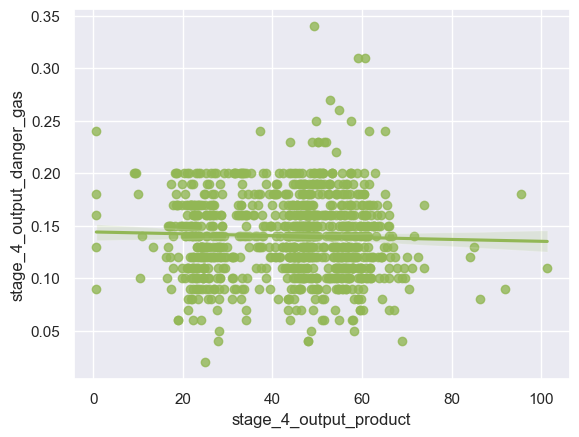

In [3578]:
sns.regplot(x='stage_4_output_product', y='stage_4_output_danger_gas', data=gip_4, color=color_for_histplot)
plt.show()

Т.к линия почти горизонтальная, то можно сказать что значение корреляции не сильно высоко

#### Составим гипотезы
H₀ = Между stage_4_output_product и stage_4_output_danger_gas нет линейной связи  
H₁ = Между stage_4_output_product и stage_4_output_danger_gas существует линейная связь  

In [3579]:
cor, p_value = spearmanr(gip_4['stage_4_output_product'], gip_4['stage_4_output_danger_gas'])
print(f"Корреляция: {cor}")
print(f"P-значение: {p_value}")

Корреляция: -0.05170761277372991
P-значение: 0.1142906451173194


P-уровень: 0.1142 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной.

### Гипотеза 5 Количество выходного продукта связано с количеством перегретого пара.

In [3580]:
gip_5 = df[['stage_4_output_product', 'stage_4_input_overheated_steam']]
gip_5.head()

stage_4_output_product  stage_4_input_overheated_steam
0                   47.03                          156.67
1                   45.05                          156.76
2                   43.06                          156.86
3                   46.01                          156.41
4                   48.95                          155.96

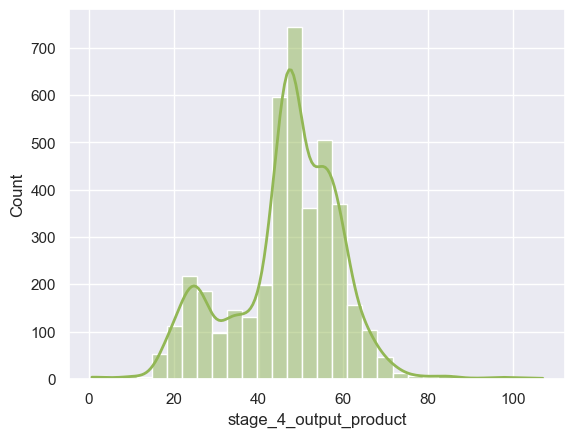

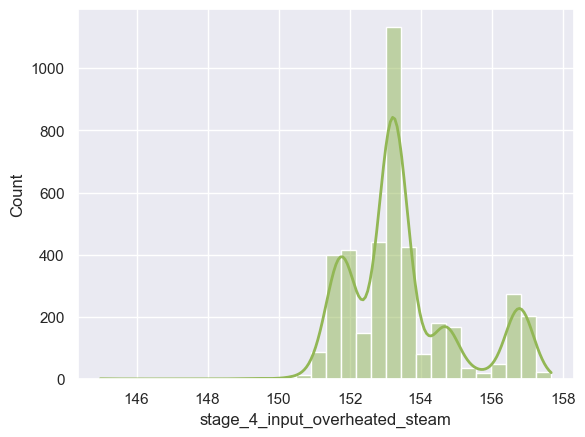

In [3581]:
sns.histplot(gip_5['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_5['stage_4_input_overheated_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3582]:
raspder(gip_5)

Параметр Распределение
0          stage_4_output_product  ненормальное
1  stage_4_input_overheated_steam  ненормальное

H₀ = Между stage_4_output_product и stage_4_input_overheated_steam нет линейной связи  
H₁ = Между stage_4_output_product и stage_4_input_overheated_steam существует линейная связь

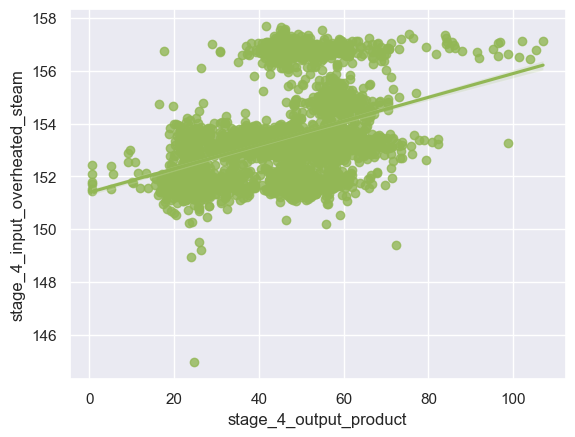

In [3583]:
sns.regplot(x='stage_4_output_product', y='stage_4_input_overheated_steam', data=gip_5, color=color_for_histplot)
plt.show()

In [3584]:
cor, p_value = spearmanr(gip_5['stage_4_output_product'], gip_5['stage_4_input_overheated_steam'])
cor, p_value

(0.3476935777752681, 1.3232433365005924e-116)

P-уровень: 1.2075581537758727e-116 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 6 Процент сухого остатка финального продукта связан с процентом конверсии сырья в мономер.

In [3585]:
gip_6 = df[['stage_4_output_dry_residue_avg', 'stage_1_output_konv_avd']]
gip_6

stage_4_output_dry_residue_avg  stage_1_output_konv_avd
0                              21.48                    67.83
1                              21.48                    67.83
2                              21.48                    67.83
3                              21.48                    67.93
4                              21.48                    68.03
...                              ...                      ...
4395                           21.18                    67.33
4396                           21.08                    68.83
4397                           21.08                    66.83
4398                           22.38                    70.03
4399                           22.18                    66.83

[4092 rows x 2 columns]

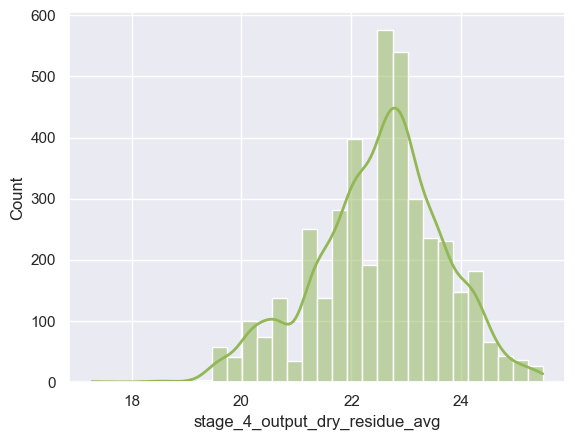

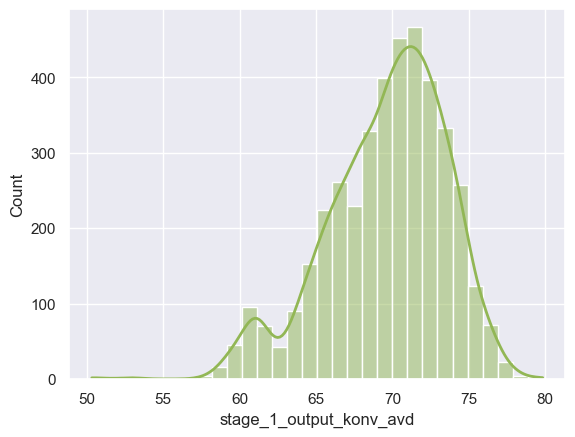

In [3586]:
sns.histplot(gip_6['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_6['stage_1_output_konv_avd'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3587]:
raspder(gip_6)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1         stage_1_output_konv_avd  ненормальное

H₀ = Между stage_4_output_dry_residue_avg и stage_1_output_konv_avd нет линейной связи  
H₁ = Между stage_4_output_dry_residue_avg и stage_1_output_konv_avd существует линейная связь

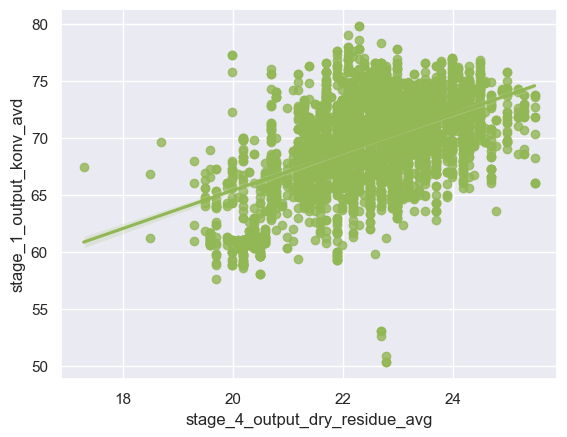

In [3588]:
sns.regplot(x='stage_4_output_dry_residue_avg', y='stage_1_output_konv_avd', data=gip_6, color=color_for_histplot)
plt.show()

In [3589]:
cor, p_value = spearmanr(gip_6['stage_4_output_dry_residue_avg'], gip_6['stage_1_output_konv_avd'])
cor, p_value

(0.4281780799506376, 3.910420164327006e-182)

P-уровень: 1.028858956200904e-177 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 7 Процент сухого остатка финального продукта связан с количеством подаваемого пара на 3м этапе.

In [3590]:
gip_7 = df[['stage_4_output_dry_residue_avg', 'stage_3_input_steam']]
gip_7

stage_4_output_dry_residue_avg  stage_3_input_steam
0                              21.48               664.93
1                              21.48               671.68
2                              21.48               678.44
3                              21.48               717.99
4                              21.48               757.55
...                              ...                  ...
4395                           21.18               447.43
4396                           21.08               528.42
4397                           21.08               532.37
4398                           22.38               504.74
4399                           22.18               529.99

[4092 rows x 2 columns]

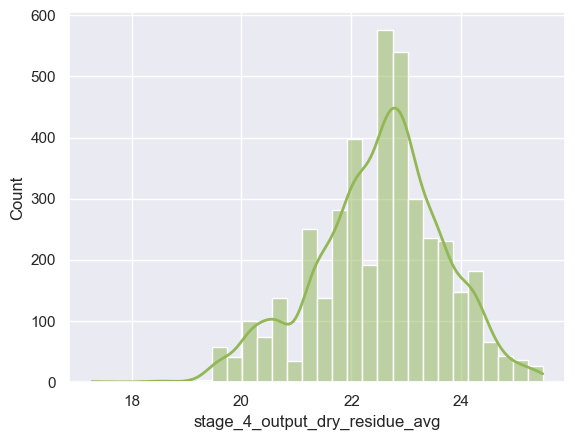

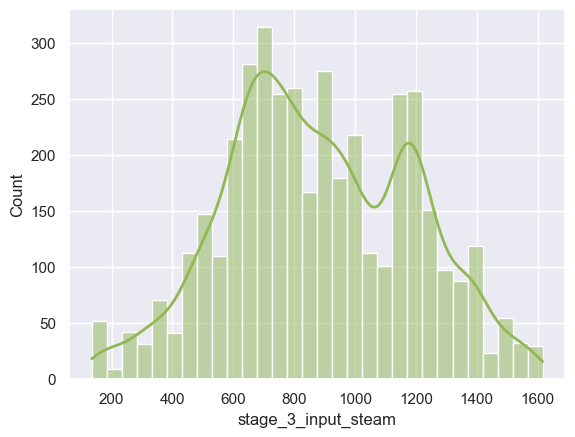

In [3591]:
sns.histplot(gip_7['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_7['stage_3_input_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3592]:
raspder(gip_7)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1             stage_3_input_steam  ненормальное

H₀ = Между stage_4_output_dry_residue_avg и stage_3_input_steam нет линейной связи  
H₁ = Между stage_4_output_dry_residue_avg и stage_3_input_steam существует линейная связь

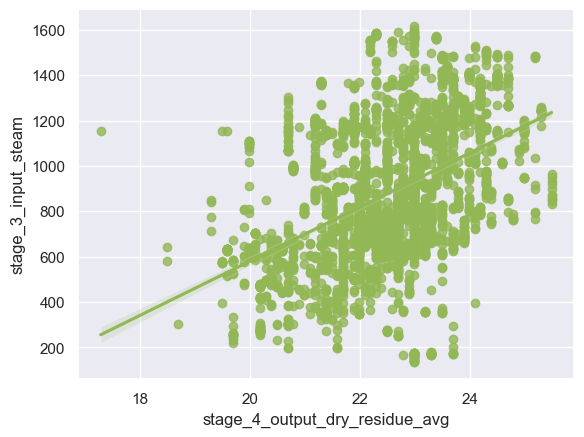

In [3593]:
sns.regplot(x='stage_4_output_dry_residue_avg', y='stage_3_input_steam', data=gip_7, color=color_for_histplot)
plt.show()

In [3594]:
cor, p_value = spearmanr(gip_7['stage_4_output_dry_residue_avg'], gip_7['stage_3_input_steam'])
cor, p_value

(0.46711833445282624, 6.418108817574982e-221)

P-уровень: 1.2888859460278866e-221 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 8 Количество итогового продукта связано с количеством мягкой воды, поданной на 3м этапе

In [3595]:
gip_8 = df[['stage_4_output_product', 'stage_3_input_soft_water']]
gip_8

stage_4_output_product  stage_3_input_soft_water
0                      47.03                    426.06
1                      45.05                    439.41
2                      43.06                    452.76
3                      46.01                    440.25
4                      48.95                    427.74
...                      ...                       ...
4395                    9.17                    107.02
4396                   10.79                    108.57
4397                    9.27                    124.21
4398                   10.11                    133.94
4399                    9.59                    109.08

[4092 rows x 2 columns]

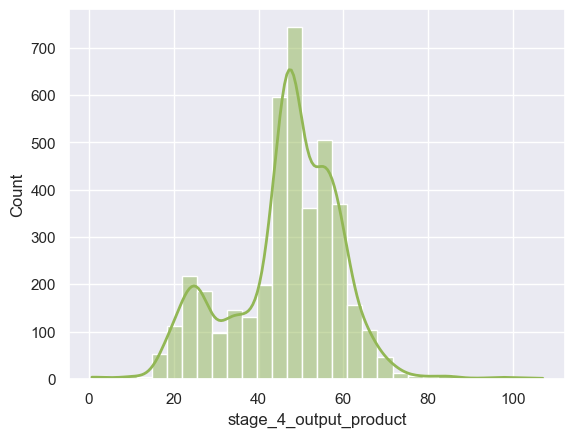

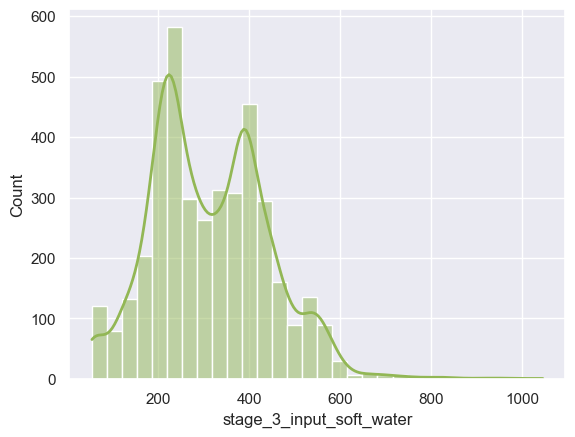

In [3596]:
sns.histplot(gip_8['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_8['stage_3_input_soft_water'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3597]:
raspder(gip_8)

Параметр Распределение
0    stage_4_output_product  ненормальное
1  stage_3_input_soft_water  ненормальное

H₀ = Между stage_4_output_product и stage_3_input_soft_water нет линейной связи  
H₁ = Между stage_4_output_product и stage_3_input_soft_water существует линейная связь

<Axes: xlabel='stage_4_output_product', ylabel='stage_3_input_soft_water'>

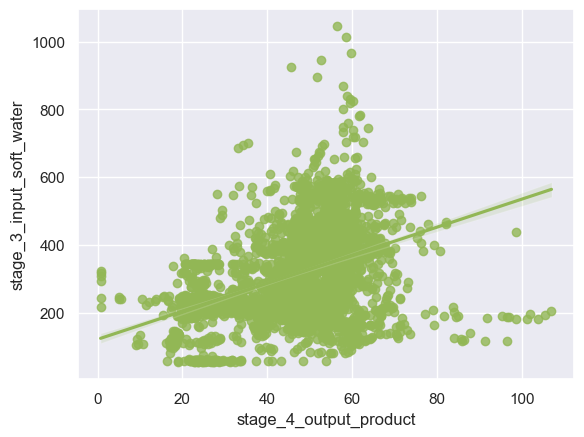

In [3598]:
sns.regplot(x='stage_4_output_product', y='stage_3_input_soft_water', data=gip_8, color=color_for_histplot)

In [3599]:
cor, p_value = spearmanr(gip_8['stage_4_output_product'], gip_8['stage_3_input_soft_water'])
cor, p_value

(0.43459946087098905, 3.4688128672169747e-188)

P-уровень: 1.708350725386925e-188 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 9 Процент сухого остатка финального продукта связан с количеством перегретого пара

In [3600]:
gip_9 = df[['stage_4_output_dry_residue_avg', 'stage_4_input_overheated_steam']]
gip_9

stage_4_output_dry_residue_avg  stage_4_input_overheated_steam
0                              21.48                          156.67
1                              21.48                          156.76
2                              21.48                          156.86
3                              21.48                          156.41
4                              21.48                          155.96
...                              ...                             ...
4395                           21.18                          152.90
4396                           21.08                          152.53
4397                           21.08                          152.53
4398                           22.38                          151.80
4399                           22.18                          153.01

[4092 rows x 2 columns]

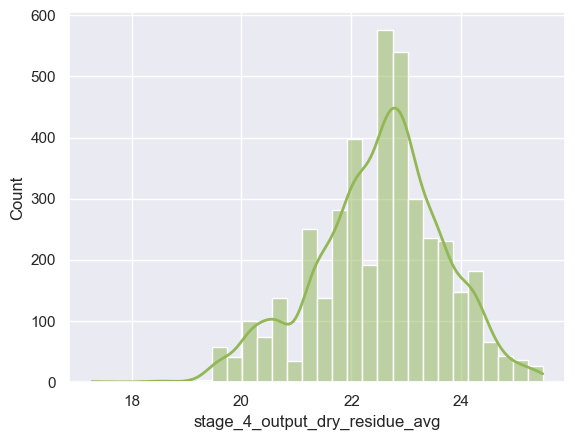

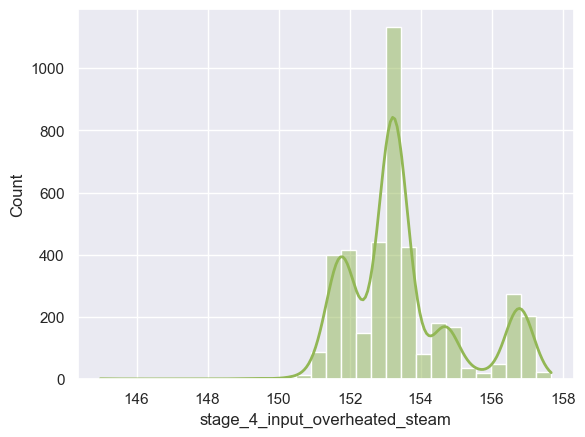

In [3601]:
sns.histplot(gip_9['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_9['stage_4_input_overheated_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3602]:
raspder(gip_9)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1  stage_4_input_overheated_steam  ненормальное

H₀ = Между stage_4_input_overheated_steam и stage_4_output_dry_residue_avg нет линейной связи  
H₁ = Между stage_4_input_overheated_steam и stage_4_output_dry_residue_avg существует линейная связь

<Axes: xlabel='stage_4_input_overheated_steam', ylabel='stage_4_output_dry_residue_avg'>

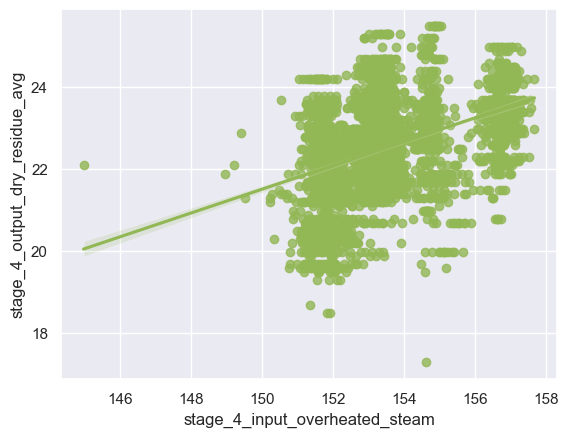

In [3603]:
sns.regplot(x='stage_4_input_overheated_steam', y='stage_4_output_dry_residue_avg', data=gip_9, color=color_for_histplot)

In [3604]:
cor, p_value = spearmanr(gip_9['stage_4_input_overheated_steam'], gip_9['stage_4_output_dry_residue_avg'])
cor, p_value

(0.3956977662919485, 1.82530590340055e-153)

P-уровень: 3.534819682295421e-153 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 10 Количество готового продукта связано с температура насыщенного пара

In [3605]:
gip_10 = df[['stage_4_output_product', 'stage_3_output_temp_hum_steam']]
gip_10

stage_4_output_product  stage_3_output_temp_hum_steam
0                      47.03                         108.65
1                      45.05                         108.71
2                      43.06                         108.76
3                      46.01                         108.63
4                      48.95                         108.51
...                      ...                            ...
4395                    9.17                         111.26
4396                   10.79                         110.09
4397                    9.27                         108.65
4398                   10.11                         108.18
4399                    9.59                         110.13

[4092 rows x 2 columns]

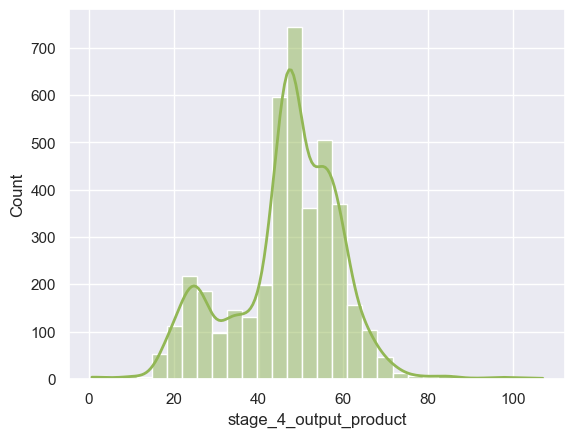

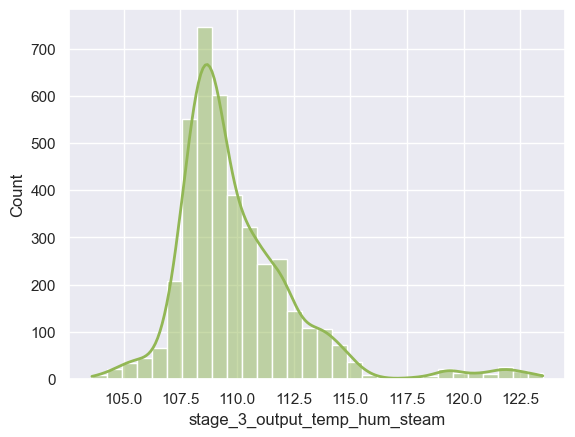

In [3606]:
sns.histplot(gip_10['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_10['stage_3_output_temp_hum_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [3607]:
raspder(gip_10)

Параметр Распределение
0         stage_4_output_product  ненормальное
1  stage_3_output_temp_hum_steam  ненормальное

H₀ = Между stage_4_output_product и stage_3_output_temp_hum_steam нет линейной связи  
H₁ = Между stage_4_output_product и stage_3_output_temp_hum_steam существует линейная связь

In [3608]:
cor, p_value = spearmanr(gip_10['stage_4_output_product'], gip_10['stage_3_output_temp_hum_steam'])
cor, p_value

(0.15748263658959802, 3.896116535795647e-24)

P-уровень: 7.193313357432421e-24 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

## Регрессионное моделирование

### Моделирование для доли опасного газа

In [3609]:
df.dropna(subset=['stage_4_output_danger_gas'], inplace=True)

Index(['datetime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift', 'danger_gas_kat'],
      dtype='object')


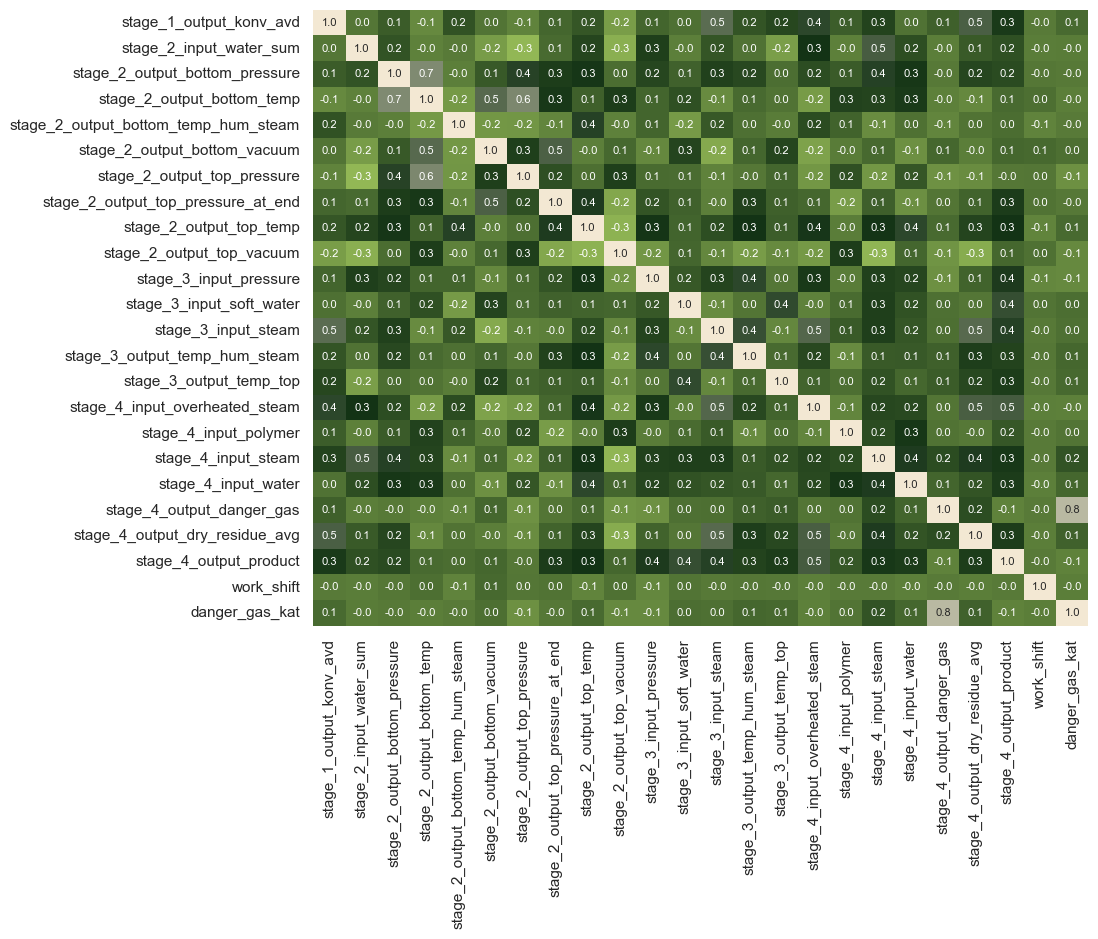

In [3610]:
custom_gradient = LinearSegmentedColormap.from_list("CorporateGradient", corporate_colors)
spec_df = df.drop('datetime', axis=1)
correlation_matrix = spec_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap=custom_gradient, fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})
print(df.columns)

In [3611]:
target_column = 'stage_4_output_danger_gas'
features = df[['stage_1_output_konv_avd', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_top_vacuum', 'stage_2_output_top_temp', 'stage_3_input_pressure', 'stage_3_output_temp_hum_steam', 'stage_3_output_temp_top', 'stage_4_input_steam', 'stage_4_input_water']]

In [3612]:
X = features
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3613]:
model = LinearRegression()

In [3614]:
model.fit(X_train, y_train)

LinearRegression()

In [3615]:
y_pred = model.predict(X_test)

In [3616]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Средняя абсолютная ошибка в процентах (MAPE): {MAPE}")
print(f"Коэффициент детерминации (R^2): {r2}")

Средняя абсолютная ошибка в процентах (MAPE): 0.24040602484205562
Коэффициент детерминации (R^2): 0.06008714771473711


In [3617]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

                                      Coefficient
stage_1_output_konv_avd                  0.000469
stage_2_output_bottom_temp_hum_steam    -0.000080
stage_2_output_top_vacuum               -0.000333
stage_2_output_top_temp                 -0.000134
stage_3_input_pressure                  -0.146952
stage_3_output_temp_hum_steam            0.001513
stage_3_output_temp_top                 -0.000013
stage_4_input_steam                      0.008288
stage_4_input_water                      0.000026


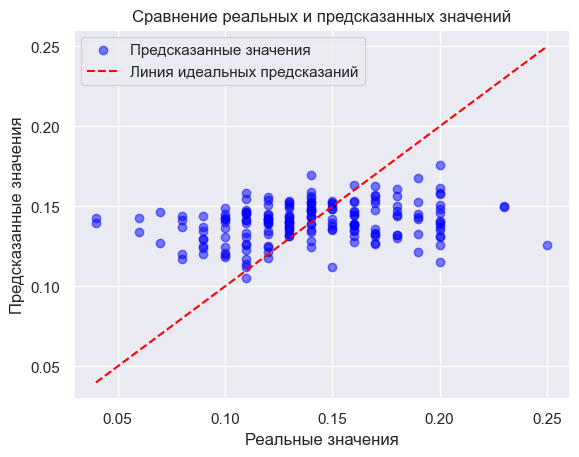

In [3618]:
real_values = y_test
predicted_values = y_pred

plt.scatter(real_values, predicted_values, color='blue', alpha=0.5, label='Предсказанные значения')
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--', label='Линия идеальных предсказаний')


plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()